In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from matplotlib.patches import Circle
from scipy.special import gamma
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad, nquad, simps
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.patches as patches
from itertools import product
from scipy.integrate import quad
import scipy.optimize as optimize
from  scipy.interpolate import interp1d
from scipy.misc import derivative
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import glob
from unsio import *
import os
import wkbl
from wkbl.astro.halo_info import *
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
from iminuit import Minuit, describe, Struct
import probfit
import cfalcon
CF =cfalcon.CFalcon()
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
import datetime
from scipy.misc import derivative
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
labelsize = 30
tickssize = 19
textsize = 15
hydro = MochimaHydro()
dmo = Mochimadmo()
center_in_pot=True

In [3]:
#halo = HALOBHydro(where="home") 
simname=hydro.name
pathsim = "/data/OWN/SF1test/SF0/mstar1_T3600/output_00041"
pathsim = hydro.path
myhydro = wkbl.Galaxy_Hound(pathsim)
myhydro.center_shift(hydro.c_pot)
myhydro.r_virial(600,n=25)


loading Dark matter..
loading Stars..
no stars log
loading Gas..
36837.902
[20415.17962488 17564.52714926 17121.29102275]
| r_200 = 212.70
| Diagonal matrix computed 
|    | 12, 0, 0|
| D =| 0, 9, 0|
|    | 0,  0, 2|


In [4]:
pos_dm = np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32)
pos_gs = np.array(myhydro.gs.pos3d.reshape(len(myhydro.gs.pos3d)*3),dtype=np.float32)
pos_st = np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),dtype=np.float32)
pos = np.concatenate((pos_dm, pos_st, pos_gs))
phi_cord = np.concatenate((myhydro.dm.phi,myhydro.st.phi, myhydro.gs.phi))

mass = np.concatenate((myhydro.dm.mass,myhydro.st.mass,myhydro.gs.mass))
v = np.concatenate((myhydro.dm.v,myhydro.st.v,myhydro.gs.v))
print len(mass)*3, len(pos)
pos3d = pos.reshape(len(pos)/3,3)
r2 = pos3d[:,0]**2 + pos3d[:,1]**2 +pos3d[:,2]**2

ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),dtype=np.float32), myhydro.dm.mass)
ok, acc, Phy = CF.getGravity(pos,mass,0.15,G=myhydro.p.G)
Phy = Phy * myhydro.p.kpctokm**2

38235837 38235837


In [5]:
inside = np.where(r2<12.)
mini = np.where(Phy[inside]==Phy[inside].min())
posin=pos3d[inside]
print posin[mini]
print hydro.c_dm_com
print hydro.c_dm_com+posin[mini][0]

[[-0.01556238  0.04121011 -0.07422587]]
[20418.88714 17567.72033 17124.40448]
[20418.87157762 17567.76154011 17124.33025413]


In [5]:
print "{0:.3e}".format(np.sum(myhydro.dm.mass[myhydro.dm.r<myhydro.r200]))
print "{0:.3e}".format(np.sum(myhydro.st.mass[myhydro.st.r<myhydro.r200]))

8.203e+11
1.174e+11


In [6]:
##############################################################################################33
#########################################################################################3######

In [7]:
ok,myhydro.dm.rho,_= CF.getDensity(np.array(myhydro.dm.pos3d.reshape(len(myhydro.dm.pos3d)*3),
                                    dtype=np.float32), myhydro.dm.mass)


In [8]:
ok,myhydro.st.rho,_= CF.getDensity(np.array(myhydro.st.pos3d.reshape(len(myhydro.st.pos3d)*3),
                                    dtype=np.float32), myhydro.st.mass)

In [9]:
##############################################################################################33
#########################################################################################3######

In [10]:
# center of big neighbour
#neighbourg = myhydro.dm.rho[np.where((myhydro.dm.r<4000)&(myhydro.dm.r>myhydro.r200))].max()
#myneighbourg = myhydro.dm.pos3d[np.where(myhydro.dm.rho==neighbourg)][0]
supershell = np.where((r2>(3*myhydro.r200)**2))
neighbourg = Phy[supershell].min()
possupershell = pos3d[supershell]
myneighbourg = possupershell[np.where(Phy[supershell]==neighbourg)][0]
# its radius squared
r_nei2 = myneighbourg[0]**2 + myneighbourg[1]**2 + myneighbourg[2]**2
phi_neigh = np.arctan2(myneighbourg[1],myneighbourg[0])
print np.sqrt(r_nei2)
the_neigh = np.arccos(myneighbourg[0]/np.sqrt(r_nei2))


# distance to every point proyected to the line conecting center to neigblourg 
adyacent = (pos3d[:,0]*myneighbourg[0] + pos3d[:,1]*myneighbourg[1] + pos3d[:,2]*myneighbourg[2]) / np.sqrt(r_nei2)
# distance to each point
hipoteneuse = np.sqrt(pos3d[:,0]**2 + pos3d[:,1]**2 + pos3d[:,2]**2)
# angle of cone
alpha = np.radians(3)
cos_alpha = np.cos(alpha)
# cosine of all particles respective to their angle to the l.o.s
cos_all = adyacent / hipoteneuse 
# final selection of cone
my_cone = pos3d[np.where((cos_all)>cos_alpha)]

6041.97502511878


In [11]:
# radii from center of neighbour
r_neig = np.sqrt((pos3d[:,0] - myneighbourg[0])**2 +(pos3d[:,1] - myneighbourg[1])**2 +(pos3d[:,2] - myneighbourg[2])**2 )
# calculating the R200 of neighbout
mhist, rhist = np.histogram(r_neig,range=(0.0,np.sqrt(r_nei2)),bins=512, weights=mass )
vol_bin = (4./3.)*np.pi*(rhist[:-1]**3)
r_bin = rhist[:-1]+ 0.5*(rhist[2]-rhist[1])
rho_s = np.cumsum(mhist) / vol_bin
r200_neigh = r_bin[np.argmin(np.abs(rho_s - (200 * myhydro.p.rho_crit)))]
# mass of neighbour
mass_neigh = np.sum(mass[np.where(r_neig<r200_neigh)])
print "the biggest neighbourg has a mass of {0:.4e} Msun and a r200 of {1:.4f} kpc".format(mass_neigh,r200_neigh)
print "and it is located at {0:.4f} kpc from de center of our halo ".format(np.sqrt(r_nei2))

the biggest neighbourg has a mass of 8.7400e+12 Msun and a r200 of 442.5275 kpc
and it is located at 6041.9750 kpc from de center of our halo 


In [12]:
los_condition = np.where((cos_all)>cos_alpha)
cone_pos = my_cone
cone_mass = mass[los_condition]
cone_Phy = Phy[los_condition]
cone_r2 = my_cone[:,0]**2 + my_cone[:,1]**2 + my_cone[:,2]**2
# now the histogram
bin_num = 1000
pot_los, bins_pot_los = np.histogram(cone_r2,bins=bin_num,
                                 weights=cone_Phy)
n_los, _ = np.histogram(cone_r2,bins=bin_num)


In [13]:
#a proyection Story
th,ph,ep = the_neigh, phi_neigh, -3*np.pi/4.
Ct, Cp, Ce = np.cos(th),np.cos(ph), np.cos(ep)
St, Sp, Se = np.sin(th),np.sin(ph), np.sin(ep)
#the rotation matrix
rot = np.array([[(Ce*Ct*Cp)+(Se*Sp),(Ce*Ct*Sp)-(Se*Cp),Ce*St],\
                [(Se*Ct*Cp)-(Ce*Sp),(Se*Ct*Sp)+(Ce*Cp),Se*St],\
                [-Cp*St,-St*Sp,Ct]])
cone_prox = rot[0,0]*cone_pos[:,0]+rot[0,1]*cone_pos[:,1]+rot[0,2]*cone_pos[:,2]
cone_proy = rot[1,0]*cone_pos[:,0]+rot[1,1]*cone_pos[:,1]+rot[1,2]*cone_pos[:,2]
neig_prox = rot[0,0]*myneighbourg[0]+rot[0,1]*myneighbourg[1]+rot[0,2]*myneighbourg[2]
neig_proy = rot[1,0]*myneighbourg[0]+rot[1,1]*myneighbourg[1]+rot[1,2]*myneighbourg[2]

In [14]:
bins_pot_los = np.linspace(0.,myhydro.dm.r.max(),512)
mean_phi_los = np.array([])
std_phi_los = np.array([])
r_phi_los = np.array([])
for i in range(len(bins_pot_los)-1):
    contidion = (cone_r2>bins_pot_los[i]**2)&(cone_r2<bins_pot_los[i+1]**2)
    mean_phi_los = np.append(mean_phi_los,np.average(cone_Phy[contidion]))
    std_phi_los = np.append(std_phi_los,np.std((cone_Phy[contidion])))
    r_phi_los = np.append(r_phi_los, ((bins_pot_los[i])+(bins_pot_los[i+1]))/2)
    
    

In [15]:
tonei = (r_phi_los<np.sqrt(r_nei2))
r_relevant = r_phi_los[tonei]
R_MAXH = r_relevant[mean_phi_los[tonei]==np.nanmax(mean_phi_los[tonei])][0]
pot_maxH = np.nanmax(mean_phi_los[tonei])
print "r_neigh = {0:.2f} kpc, r_max = {1:0.2f} kpc, pot_max = {2:.2f} pc km^2 M_sun s^-2".format(np.sqrt(r_nei2),R_MAXH, pot_maxH)

r_neigh = 6041.98 kpc, r_max = 1634.02 kpc, pot_max = -62177.69 pc km^2 M_sun s^-2


In [16]:
#R_MAXH = 1725.09
#pot_maxH = -21926.61

<IPython.core.display.Javascript object>


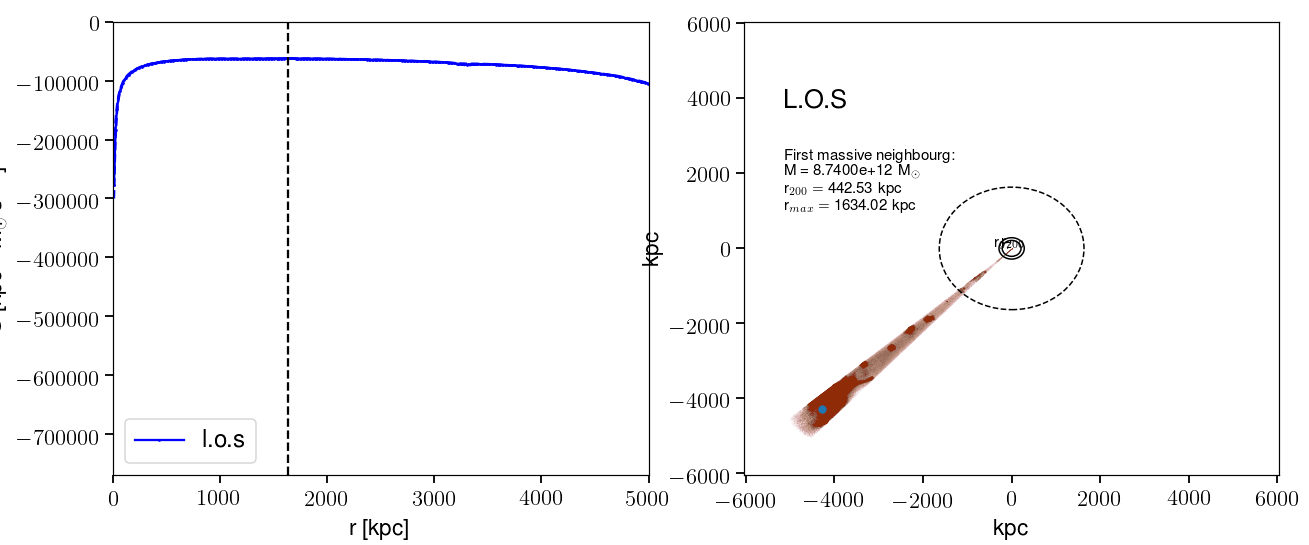

In [17]:

fig, ax = plt.subplots(1,2,figsize=[12,5])

#fig, ax[0] = plt.subplots()
ax[0].set_xlim([0,5000])
ax[0].set_ylim([-7.7e5,0])
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax[0].set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax[0].set_xlabel(r'r [kpc] ', fontsize=15)
ax[0].plot(r_phi_los, mean_phi_los+std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los-std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los, 'bo-',markersize=0.8,label="l.o.s")
#ax[0].plot(r_phi,mean_phi,color='gray',ls='-', label='Shell')
#ax[0].plot(r_phi,mean_phi+std_phi,color='gray',ls='--')
#ax[0].plot(r_phi,mean_phi-std_phi,color='gray',ls='--')
ax[0].axvline(x=R_MAXH,color='k',linestyle='--')

r_fin = np.sqrt(r_nei2)
ax[1].set_ylim([-r_fin,r_fin])
ax[1].set_xlim([-r_fin,r_fin])
ax[1].set_xlabel(r' kpc ', fontsize=15)
ax[1].set_ylabel(r' kpc ', fontsize=15)
texto_neigh = "First massive neighbourg: \n"
texto_neigh += "M = {0:.4e}".format(mass_neigh)
texto_neigh += r" M$_{\odot}$"+"\n"
texto_neigh += r"r$_{200} = $ "+"{0:.2f} kpc\n".format(r200_neigh)
texto_neigh += r"r$_{max} = $ "+"{0:.2f} kpc".format(float(R_MAXH))
fig.text(.6,.8,"L.O.S",fontsize=17)
fig.text(.6,.61,texto_neigh)
#ax[1].scatter(my_cone[:,0], my_cone[:,1],c="#902b08",lw=0,s=0.04,alpha=0.6)
ax[1].scatter(-cone_prox, -cone_proy,c="#902b08",lw=0,s=0.01,alpha=0.4)

#ax[1].scatter(myneighbourg[0],myneighbourg[1],s=20)
ax[1].scatter(-np.sqrt(r_nei2)*np.cos(np.pi/4.),-np.sqrt(r_nei2)*np.sin(np.pi/4.),s=30,lw=0)
circle = plt.Circle(((0),(0)),myhydro.r200, color='k',lw=1, fill=False)
ax[1].add_patch( circle )
circle = plt.Circle(((0),(0)),myhydro.r97, color='k',lw=1, fill=False)
ax[1].add_patch( circle )
circle = plt.Circle(((0),(0)),R_MAXH, color='k',ls='--',lw=1, fill=False)
ax[1].add_patch( circle )
ax[1].text(-myhydro.r200-15,20,r'r$_{200}$')
ax[1].text(-myhydro.r97-100,-20,r'r$_{97}$')

circle = plt.Circle((np.sqrt(r_nei2)*np.cos(np.pi/4.),np.sqrt(r_nei2)*np.sin(np.pi/4.)),r200_neigh, color='w',lw=0.9, fill=False)
ax[1].add_patch( circle )


legend = ax[0].legend(loc='lower left', ncol=1, shadow=False, fontsize=16)
frame = legend.get_frame()
fig.tight_layout(w_pad=0)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#fig.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/Rmax.pdf")

In [28]:
#pot_maxH = -30000
#pot_maxH = -24605.33
#R_MAXH = 804.73

In [37]:
potdatDMO = np.loadtxt("../../../datafiles/Psi_halo_B_DMO_Rmax=805.0kpc_dimensionful.txt")
potdatHyd = np.loadtxt("../../../datafiles/Psi_halo_B_DM_baryons_Rmax=805.0kpc_dimensionful.txt")


In [30]:
bins_pot = np.logspace(-0.5,np.log10(myhydro.dm.r.max()),100)
mean_phi = np.array([])
std_phi = np.array([])
r_phi = np.array([])
for i in range(len(bins_pot)-1):
    contidion = (r2>bins_pot[i]**2)&(r2<bins_pot[i+1]**2)   
    mean_phi = np.append(mean_phi,np.average(Phy[contidion]))
    std_phi = np.append(std_phi,np.std((Phy[contidion])))
    r_phi = np.append(r_phi, ((bins_pot[i])+(bins_pot[i+1]))/2)

In [31]:
##### this is for hydro
rho = np.array([7.414, 7.364, 1.768, 2.633, 0.468])

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

def TM_dm(r_end,rho_s):
    def integrand1(r):
        return 4* np.pi* (r**2) * (abg_profile(r,rho_s,rho[1],rho[2],rho[3],rho[4]))
    return quad(integrand1,0, r_end)[0]

def TM2_dm(r,rho_s):
    def integrand1(r):
        return 4* np.pi* r * (abg_profile(r,rho_s,rho[1],rho[2],rho[3],rho[4]))
    return quad(integrand1,r, R_MAXH)[0]

def stars(R,z,B_0,r0,al,r_cut,q,d_0,z_d,Rd,D_0,z_D,RD):
    def McMBulge(U,B_0,r0,al,r_cut):
        x = np.sqrt(U[0]**2 + (U[1]/q)**2)
        bulge = (10**B_0) * np.exp(-(x/r_cut)**2) / (1 + (x/r0))**al
        return bulge

    def McMDisc(x,z,z_d,D_0,Rd):
        disc = (10**D_0) * np.exp(- (abs(z) / z_d) - (x / Rd))
        return disc
    U = [R,z]
    return (McMBulge(U,B_0,r0,al,r_cut)+McMDisc(U[0],U[1],z_d,d_0,Rd)+McMDisc(U[0],U[1],z_D,D_0,RD))

def gas(R,z,D_0,z_d,Rd):        
    return (10**D_0) * np.exp( - (R / Rd)) / (np.cosh(z /2./ z_d))**2


st = np.array([9.381, 0.678, 0.381, 1.063, 0.677, 7.384, 1.049, 2.098, 8.892, 1.067, 3.017])

def TM_st(r_end,B_s,d_s,D_s):
    def integrand(r,theta):
        
        return 2*np.pi*np.sin(theta)* r**2 * (stars(r*np.sin(theta),r*np.cos(theta),B_s,st[1],st[2],st[3],st[4],d_s,st[6],st[7],D_s,st[9],st[10]))
    
    return nquad(integrand,[[0.0,r_end],[0.0,np.pi]])[0]

gs = np.array([8.497, 0.119, 5.971])

def TM_gs(r_end,D_s):
    def integrand(r,theta):
        
        return 2*np.pi*np.sin(theta)* r**2 * (gas(r*np.sin(theta),r*np.cos(theta),D_s,gs[1],gs[2]))
    
    return nquad(integrand,[[0.0,r_end],[0.0,np.pi]])[0]

def TM2_st(r_end,B_s,d_s,D_s):
    def integrand(r,theta):
        
        return 2*np.pi *np.sin(theta)* r * (stars(r*np.sin(theta),r*np.cos(theta),B_s,st[1],st[2],st[3],st[4],d_s,st[6],st[7],D_s,st[9],st[10]))
    
    return nquad(integrand,[[r_end,R_MAXH],[0,np.pi]])[0]

def TM2_gs(r_end,D_s):
    def integrand(r,theta):
        
        return 2*np.pi *np.sin(theta)* r * (gas(r*np.sin(theta),r*np.cos(theta),D_s,gs[1],gs[2]))
    
    return nquad(integrand,[[r_end,R_MAXH],[0,np.pi]])[0]

In [32]:
g_factor = (myhydro.p.pctocm*10)**2 / 1e6
G_phiunits = myhydro.p.G * g_factor

r_mass = np.logspace(0,np.log10(6*myhydro.r200), 100)
mass_sim =np.array([np.sum(mass[r2<i**2]) for i in r_mass])
phi_mass = np.array([(np.trapz(mass_sim[:i]/r_mass[:i]**2,x=r_mass[:i])) for i in range(len(r_mass))])
minmin = (np.abs(r_mass-R_MAXH)==np.abs(r_mass-R_MAXH).min())
phi_massH = (G_phiunits*phi_mass[minmin])-(G_phiunits*phi_mass)

def full_potential(rho_s,B_s,d_s,D_s):
    # firt term in equation 3.22 magni's thesis
    mass_fit = np.array([TM_dm(i,rho_s) for i in r_mass])
    mass_fit_st = np.array([TM_st(i,B_s,d_s,D_s) for i in r_mass])
    # second term in equation 3.22 magni's thesis
    mass_fit2 = np.array([TM2_dm(i,rho_s) for i in r_mass])
    mass_fit_st2 = np.array([TM2_st(i,B_s,d_s,D_s) for i in r_mass])
    Psi = - G_phiunits *((mass_fit/r_mass)+mass_fit2+(mass_fit_st/r_mass)+mass_fit_st2)
    chi = np.log10(Psi[minmin]-Psi)-np.log10(phi_massH)
    return np.sum(chi)**2


In [33]:
### takes some time
# this is for Hydro
r_mass = np.logspace(0,np.log10(R_MAXH), 100)
mass_sim =np.array([np.sum(mass[r2<i**2]) for i in r_mass])
phi_mass = np.array([(np.trapz(mass_sim[:i]/r_mass[:i]**2,x=r_mass[:i])) for i in range(len(r_mass))])
g_factor = (myhydro.p.pctocm*10)**2 / 1e6
G_phiunits = myhydro.p.G * g_factor
### BEWARE HARD NUMBER ALERT
effective_Rmax = R_MAXH# - 800
minmin = (np.abs(r_mass-effective_Rmax)==np.abs(r_mass-effective_Rmax).min())
phi_massH = (G_phiunits*phi_mass[minmin])-(G_phiunits*phi_mass)

In [34]:
print "cooc"

cooc


In [35]:
#st = np.array([8.7,0.200,1.280,2.426,0.400,8.68, 0.481, 3.559, 7.8, 1.046, 7.069])

# firt term in equation 3.22 magni's thesis
mass_fit = np.array([TM_dm(i,rho[0]) for i in r_mass])
mass_fit_st = np.array([TM_st(i,st[0],st[5],st[8]) for i in r_mass])
mass_fit_gs = np.array([TM_gs(i,gs[0]) for i in r_mass])

# second term in equation 3.22 magni's thesis
mass_fit2 = np.array([TM2_dm(i,rho[0]) for i in r_mass])
mass_fit_st2 = np.array([TM2_st(i,st[0],st[5],st[8]) for i in r_mass])
mass_fit_gs2 = np.array([TM2_gs(i,gs[0]) for i in r_mass])
print "now making Psi"
Psi = - G_phiunits *((mass_fit/r_mass)+mass_fit2+(mass_fit_st/r_mass)+mass_fit_st2+(mass_fit_gs/r_mass)+mass_fit_gs2)

now making Psi


<IPython.core.display.Javascript object>


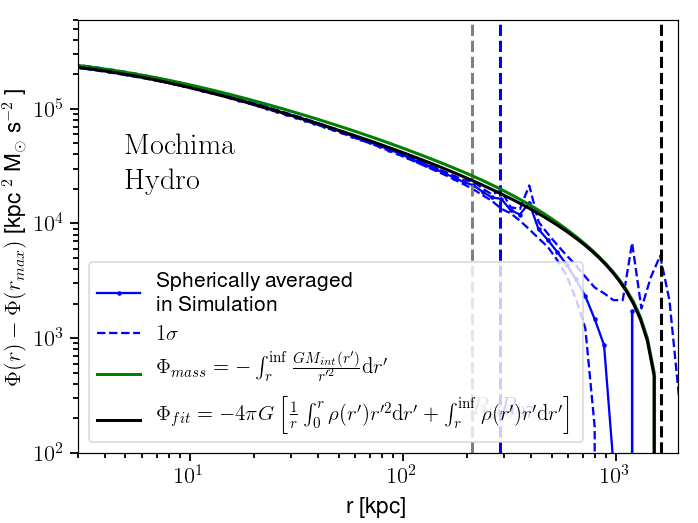

[-58686.75]


In [38]:
fig, ax = plt.subplots()
#ax.set_xlim([1,potdatHyd[:,0].max()])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([3,1.2 * R_MAXH ])
ax.set_ylim([1e2,6e5])
ax.set_ylabel(r'$\Phi(r) - \Phi(r_{max})$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
ax.set_xlabel(r'r [kpc] ', fontsize=15)
"""
ax.plot(r_phi_los, mean_phi_los+std_phi_los, 'b--')
ax.plot(r_phi_los, mean_phi_los-std_phi_los, 'b--')
ax.plot(r_phi_los, mean_phi_los, 'bo-',markersize=0.8,label="l.o.s")
"""


elmin = (np.abs(r_phi-R_MAXH)==np.abs(r_phi-R_MAXH).min())
print mean_phi[elmin]
ax.plot(r_phi,mean_phi[elmin]-mean_phi,'bo-',markersize=2,label="Spherically averaged\nin Simulation")
ax.plot(r_phi,mean_phi[elmin]-mean_phi+std_phi,'b--')
ax.plot(r_phi,mean_phi[elmin]-mean_phi-std_phi,'b--',label=r"$1 \sigma$")
ax.axvline(x=R_MAXH,color='k',linestyle='--',lw=2)
ax.axvline(x=myhydro.r200,color='gray',linestyle='--',lw=2)
ax.axvline(x=myhydro.r97,color='b',linestyle='--',lw=2)
ax.text(myhydro.r200,200,r"$R_{200}$",color='gray',fontsize=16)
ax.text(myhydro.r97,200,r"$R_{97}$",color='b',fontsize=16)
ax.text(5,2e4,r"$\rm "+simname+ "$"+"\n"+r"$\rm Hydro$",color='k',fontsize=20)
#ax.yaxis.set_major_formatter(FormatStrFormatter('%1.e'))

phimass_legend = r"$\Phi_{mass} = -\int_r ^{\inf} \frac{G M_{int}(r')}{r'^2}\mathrm{d}r'$"
ax.plot(r_mass,phi_massH,'g-',lw=2, label=phimass_legend )
phirho_legend = r"$\Phi_{fit} = -4\pi G\left[\frac{1}{r}\int_0^{r}\mathrm{\rho}(r')r'^2\mathrm{d}r' + \int_{r}^{\inf}\mathrm{\rho}(r')r'\mathrm{d}r'     \right]$"
#ax.plot(r_mass,phi_fitH,'m-',lw=2, label=phirho_legend )


#ax.plot(potdatHyd[:,0],potdatHyd[:,1],"r--", lw=2,label="reconstructed")
ax.plot(r_mass,Psi[minmin]-Psi,'k',lw=2,label=phirho_legend)

legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=14)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

# $v_{esc}$

In [39]:
bin_num = 50
times = 3.
bins = np.logspace(np.log10(3*myhydro.gs.hsml.min()),np.log10((times*myhydro.r200)**2),bin_num)
pot_sph_vesc, bins_pot_vesc = np.histogram(r2[(r2<(times*myhydro.r200)**2)],bins=bins)

def vesc_from_pot(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    contidion = (r2>limmin**2)&(r2<limmax**2)
    mean = np.average(Phy[contidion])
    sigma = np.std((Phy[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_max))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 

mean_phi_vesc = np.array([])
std_phi_vesc = np.array([])
r_phi_vesc = np.array([])
for i in range(len(bins_pot_vesc)-1):
    contidion = (r2>bins_pot_vesc[i])&(r2<bins_pot_vesc[i+1])
    mean_phi_vesc = np.append(mean_phi_vesc,np.mean(Phy[contidion]))
    std_phi_vesc = np.append(std_phi_vesc,np.std(Phy[contidion]))
    r_phi_vesc = np.append(r_phi_vesc, (np.sqrt(bins_pot_vesc[i])+np.sqrt(bins_pot_vesc[i+1]))/2)
    
##################################
v_esc = np.sqrt(2*np.abs(mean_phi[elmin]-mean_phi_vesc ))
sig_vesc = std_phi_vesc / v_esc 


In [58]:
def flash_per_r(rmin, rmax):
    in_the_shell = (myhydro.dm.r > rmin)&(myhydro.dm.r < rmax)
    result = myhydro.dm.v[in_the_shell]
    orde = result[np.argsort(result)]
    return orde[-3],orde[-2],orde[-1]
get_fastest = np.vectorize(flash_per_r)


In [54]:
limmin, limmax = 7.5, 8.5
def slice_vmax(rmin, rmax,phimin,phimax):
    """
    takes a section of the spherical shell of
    rmin < r < rmax
    phimin < phi < phimax
    """
    in_the_shell = (myhydro.dm.r > rmin)&(myhydro.dm.r < rmax)
    in_the_slice = (myhydro.dm.phi > phimin)&(myhydro.dm.phi < phimax)
    result = myhydro.dm.v[in_the_shell&in_the_slice]
    return result.max(),len(result)
slice_vesc  = np.vectorize(slice_vmax)



def vesc_per_radius(rmin, rmax,n=20):
    """
    generalization of the slice_vmax method
    to extract the v_max in n slices between 
    rmin and rmax
    return: mean and sigma of the obtained dist.
    """
    slices = np.linspace(-np.pi,np.pi,n)
    v_maxs, N = slice_vesc(rmin,rmax,slices[:-1],slices[1:])
    return np.mean(v_maxs), np.std(v_maxs), np.sum(N)



get_vesc_from_slices = np.vectorize(vesc_per_radius)    

unbound_dm = dm_inside = st_inside = unbound_st = shell_vol = rho_max_bin = np.array([])
bins_lin = np.sqrt(bins_pot_vesc)
for i in range(len(bins_pot_vesc)-1):
    inside_bin_dm = np.where((myhydro.dm.r>=bins_lin[i])&(myhydro.dm.r<bins_lin[i+1]))
    inside_bin_st = np.where((myhydro.st.r>=bins_lin[i])&(myhydro.st.r<bins_lin[i+1]))
    dm_inside = np.append(dm_inside,len(myhydro.dm.mass[inside_bin_dm]))
    st_inside = np.append(st_inside,len(myhydro.st.mass[inside_bin_st]))
    unbound_dm = np.append(unbound_dm, len(np.where(myhydro.dm.v[inside_bin_dm]>v_esc[i])[0]))
    unbound_st = np.append(unbound_st,len(np.where(myhydro.st.v[inside_bin_st]>v_esc[i])[0]))
    shell_vol = np.append(shell_vol, 4.* np.pi * ((bins_lin[i+1]**3)-(bins_lin[i]**3)) / 3.)
    rho_max_bin = np.append(rho_max_bin, myhydro.dm.rho[inside_bin_dm].mean())

In [67]:
slices = np.linspace(-np.pi,np.pi,20)
an_array = np.logspace(-0.1,3,40)
#vesc_per_radius = get_vesc_from_slices(np.sqrt(bins_pot_vesc[:-1]),np.sqrt(bins_pot_vesc[1:]))
vesc_per_radius = get_vesc_from_slices(an_array[:-1],an_array[1:])
r_phi_centers = (an_array[:-1]+an_array[1:])/2.
third_fastest, second_fastest, fastest = get_fastest(an_array[:-1],an_array[1:])

<IPython.core.display.Javascript object>


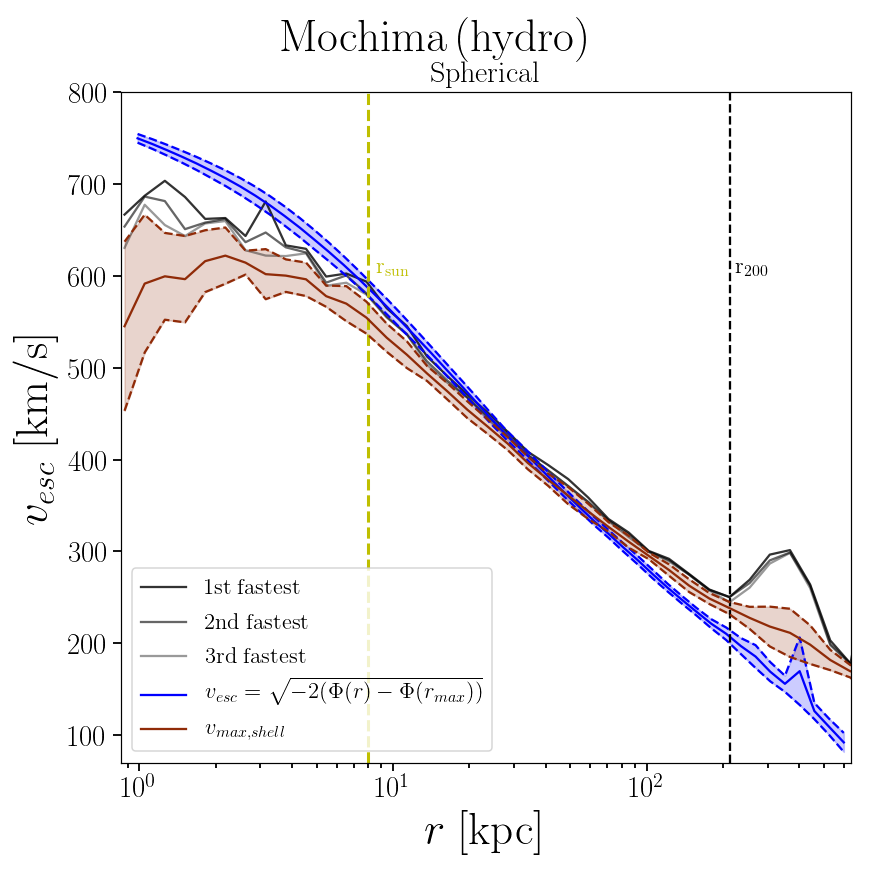

In [89]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([3.*myhydro.gs.hsml.min(),3*myhydro.r200])
ax.set_ylim([70,800])
ax.set_xscale('log')
font = 17
fig.suptitle(r"    $\rm \,\,\,\,\,\,\,\,"+simname+"\,(hydro)$",fontsize=30)
ax.set_title(r"$\rm Spherical$",fontsize=20)
### order
ax.plot(r_phi_centers,fastest,'k',alpha=0.8,linestyle="-",label=r"$\rm 1st\;fastest$")
ax.plot(r_phi_centers,second_fastest,'k',alpha=0.6,linestyle="-",label=r"$\rm 2nd\;fastest$")
ax.plot(r_phi_centers,third_fastest,'k',alpha=0.4,linestyle="-",label=r"$\rm 3rd\;fastest$")
##### from potential
ax.plot(r_phi_vesc, v_esc,'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3)
#ax.plot(r_phi_vesc+2000, v_esc+sig_vesc+2000,color='gray', linestyle='--',label=r"1$\sigma$")
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.fill_between(r_phi_vesc,v_esc+sig_vesc, v_esc-sig_vesc,color='b',alpha=0.2)
ax.set_xlabel(r"$r\rm  \;[kpc]$",fontsize=labelsize)
ax.set_ylabel(r"$v_{esc}\rm \;[km/s] $",fontsize=labelsize)
ax.axvline(x=myhydro.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell
ax.plot(r_phi_centers,vesc_per_radius[0],color="#902b08",linestyle="-",label=r"$v_{max,shell}$")



ax.plot(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_centers,vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",linestyle="--")
ax.fill_between(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
#ax1.plot(r_phi_vesc,(vesc_per_radius[0]-v_esc)/v_esc,'r-',lw=2,label=r"$v_{esc}$ from mass")
ax.text(myhydro.r200+10,600,r"$\rm r_{200}$",fontsize=textsize)
ax.text(8.6,600,r"$\rm r_{sun}$",color='y',fontsize=textsize)

fig.tight_layout(h_pad=-0.90)
#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="from fit (Magni 3.22)")
#ax.plot(r_mass,np.sqrt(2*phi_massH),'g',label="from mass (Magni 3.1)")

legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=textsize)
frame = legend.get_frame()




ax.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)
fig.tight_layout(rect=(0,0,1,0.95))
#plt.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/v_esc.png",dpi=300)

In [47]:
th_points = np.array([3.,8.,20.,50.,150.])
ves_point = sig_points = r_points = np.array([])
for i in th_points:
    r_points = np.append(r_points, r_phi_centers[np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])
    ves_point = np.append(ves_point, vesc_per_radius[0][np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])
    sig_points = np.append(sig_points, vesc_per_radius[1][np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])

print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(ves_point[0],ves_point[1],ves_point[2],ves_point[3],ves_point[4] )
print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(sig_points[0],sig_points[1],sig_points[2],sig_points[3],sig_points[4] )


[612.09, 550.62, 446.70, 373.21, 258.20 ]
[23.30, 15.34, 8.71, 6.75, 5.44 ]


# isopotential

In [75]:
to = 1.5
Psi_hydro = mean_phi[elmin]-Phy 
r_all = np.sqrt(r2)
Psi_hydro = Psi_hydro[r_all<to*myhydro.r200]
r_all = r_all[r_all<to*myhydro.r200]

In [76]:

def slice_vmax_Phi(rmin, rmax,phimin,phimax):
    """
    takes a section of the spherical shell of
    rmin < r < rmax
    phimin < phi < phimax
    """
    
    local_Psi = (mean_phi[elmin]-Phy[:len(myhydro.dm.mass)])
    in_the_shell = (local_Psi[myhydro.dm.r<to*myhydro.r200] > rmin)&(local_Psi[myhydro.dm.r<to*myhydro.r200] < rmax)
    in_the_slice = (myhydro.dm.phi[myhydro.dm.r<to*myhydro.r200] > phimin)&(myhydro.dm.phi[myhydro.dm.r<to*myhydro.r200] < phimax)
    v_inside = myhydro.dm.v[myhydro.dm.r<to*myhydro.r200]
    result = v_inside[in_the_shell&in_the_slice]
    if len(result)==0:
        return np.nan,np.nan
    else:
        return result.max(),len(result)

slice_vesc_Phi  = np.vectorize(slice_vmax_Phi)

def vesc_per_Phi(Phimin, Phimax,n=20):
    """
    generalization of the slice_vmax method
    to extract the v_max in n slices between 
    rmin and rmax
    return: mean and sigma of the obtained dist.
    """
    slices = np.linspace(-np.pi,np.pi,n)
    v_maxs, N = slice_vesc_Phi(Phimin,Phimax,slices[:-1],slices[1:])
    return np.nanmean(v_maxs), np.nanstd(v_maxs), np.nansum(N)

get_vesc_from_slices_phi = np.vectorize(vesc_per_Phi)    


In [77]:
rrarray = Psi_hydro[np.argsort(Psi_hydro)]
print rrarray.min(),rrarray.max(), len(rrarray)
phi_bins = rrarray[np.array(np.linspace(0,len(rrarray)-1,100),dtype=int)]

11896.9140625 314499.6875 2543664


In [78]:

cent_phi_bins = (phi_bins[1:]+phi_bins[:-1])/2.
r_from_phi = sig_r_from_phi = np.array([])
for i in range(len(phi_bins)-1):
    condition = (Psi_hydro>phi_bins[i])&(Psi_hydro<phi_bins[i+1])
    r_from_phi = np.append(r_from_phi,np.mean(r_all[condition]))
    sig_r_from_phi = np.append(sig_r_from_phi,np.std(r_all[condition]))


In [79]:
vesc_per_pot = get_vesc_from_slices_phi(phi_bins[:-1],phi_bins[1:])

<IPython.core.display.Javascript object>


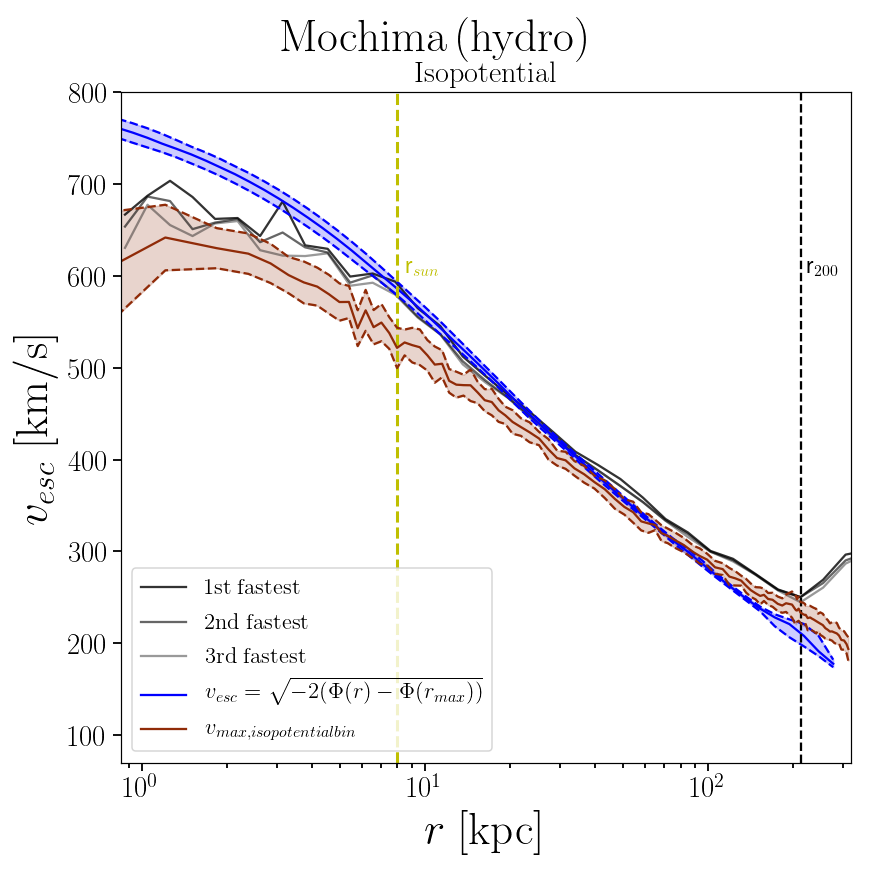

In [87]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([3.*myhydro.gs.hsml.min(),1.5*myhydro.r200])
ax.set_ylim([70,800])
ax.set_xscale('log')
font = 17
fig.suptitle(r"    $\rm \,\,\,\,\,\,\,\,Mochima\,(hydro)$",fontsize=30)
ax.set_title(r"$\rm Isopotential$",fontsize=20)
### order
ax.plot(r_phi_centers,fastest,'k',alpha=0.8,linestyle="-",label=r"$\rm 1st\;fastest$")
ax.plot(r_phi_centers,second_fastest,'k',alpha=0.6,linestyle="-",label=r"$\rm 2nd\;fastest$")
ax.plot(r_phi_centers,third_fastest,'k',alpha=0.4,linestyle="-",label=r"$\rm 3rd\;fastest$")
##### from potential
f_true = interp1d(r_from_phi, np.sqrt(2*cent_phi_bins))
f_plus = interp1d(r_from_phi+sig_r_from_phi, np.sqrt(2*cent_phi_bins))
f_min = interp1d(r_from_phi-sig_r_from_phi, np.sqrt(2*cent_phi_bins))
nunur = np.logspace(np.log10(1.1*(r_from_phi+sig_r_from_phi).min()),
                    np.log10(.9*(r_from_phi-sig_r_from_phi).max()),50)

ax.plot(nunur,f_true(nunur),'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(nunur,f_plus(nunur),'b--',markersize=3)
ax.plot(nunur, f_min(nunur),'b--',markersize=3)
ax.fill_between(nunur,f_min(nunur),f_plus(nunur),color='b',alpha=0.2)
ax.set_xlabel(r"$ r \rm \;[kpc]$",fontsize=labelsize)
ax.set_ylabel(r"$ v_{esc}\rm \; [km/s]$ ",fontsize=labelsize)
ax.axvline(x=myhydro.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell
ax.plot(r_from_phi,vesc_per_pot[0],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")
ax.plot(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],color="#902b08",linestyle="--")
ax.plot(r_from_phi,vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",linestyle="--")
ax.fill_between(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",alpha=0.2)

#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
#ax1.plot(r_phi_vesc,(vesc_per_radius[0]-v_esc)/v_esc,'r-',lw=2,label=r"$v_{esc}$ from mass")
ax.text(myhydro.r200+10,600,r"r$_{200}$",fontsize=textsize)
ax.text(8.6,600,r"r$_{sun}$",color='y',fontsize=textsize)

#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="from fit (Magni 3.22)")
#ax.plot(r_mass,np.sqrt(2*phi_massH),'g',label="from mass (Magni 3.1)")

legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=textsize)
frame = legend.get_frame()



ax.tick_params(axis='both', which='major', labelsize=tickssize, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=tickssize, size=3,width=1.2)

fig.tight_layout(rect=(0,0,1,0.95))

In [81]:
th_points = np.array([3.,8.,20.,50.,150.])
ves_point = sig_points = r_points = np.array([])
for i in th_points:
    r_points = np.append(r_points, i)
    ves_point = np.append(ves_point, f_true(i))
    sig_points = np.append(sig_points, f_plus(i)-f_true(i))

print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(ves_point[0],ves_point[1],ves_point[2],ves_point[3],ves_point[4] )
print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(sig_points[0],sig_points[1],sig_points[2],sig_points[3],sig_points[4] )


[685.66, 585.92, 470.01, 357.78, 239.14 ]
[9.54, 7.45, 4.33, 2.78, 2.06 ]


In [39]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[14,7])
fig.text(0.4,0.9,r"$\rm "+simname+"\,hydro$",fontsize=50)
#########################3333
ax.set_xlim([1,3*myhydro.r200])
ax.set_ylim([70,1.1*v_esc.max()])
ax.set_xscale('log')
font = 17
##### from potential
ax.plot(r_phi_vesc, v_esc,'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3)
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.fill_between(r_phi_vesc,v_esc+sig_vesc, v_esc-sig_vesc,color='b',alpha=0.2)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax.axvline(x=myhydro.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell spherical assumption
ax.plot(r_phi_centers,vesc_per_radius[0],color="#902b08",linestyle="-",label=r"$v_{max,shell}$")
ax.plot(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_centers,vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",linestyle="--")
ax.fill_between(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
ax.text(myhydro.r200+10,580,r"r$_{200}$",fontsize=font)
ax.text(8.6,580,r"r$_{sun}$",fontsize=font)
ax.text(20,580,r"$\rm Spherical$",fontsize=30)
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
fig.tight_layout(h_pad=-0.90)
#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="modified")
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
##############################################################################################
##############################################################################################
##############################################################################################

ax1.set_xlim([1,3*myhydro.r200])
ax.set_ylim([70,1.1*v_esc.max()])
ax1.set_xscale('log')
font = 17
##### from potential
f_true = interp1d(r_from_phi, np.sqrt(2*cent_phi_bins))
f_plus = interp1d(r_from_phi+sig_r_from_phi, np.sqrt(2*cent_phi_bins))
f_min = interp1d(r_from_phi-sig_r_from_phi, np.sqrt(2*cent_phi_bins))
nunur = np.logspace(np.log10(1.1*(r_from_phi+sig_r_from_phi).min()),
                    np.log10(.9*(r_from_phi-sig_r_from_phi).max()),50)

ax1.plot(nunur,f_true(nunur),'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax1.plot(nunur,f_plus(nunur),'b--',markersize=3)
ax1.plot(nunur, f_min(nunur),'b--',markersize=3)
ax1.fill_between(nunur,f_min(nunur),f_plus(nunur),color='b',alpha=0.2)
ax1.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax1.axvline(x=myhydro.r200,color='k',linestyle='--')
ax1.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
ax.set_xlabel("r [kpc]",fontsize=font)
ax1.set_xlabel("r [kpc]",fontsize=font)

##### from shell 
ax1.plot(r_from_phi,vesc_per_pot[0],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")
ax1.plot(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],color="#902b08",linestyle="--")
ax1.plot(r_from_phi,vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",linestyle="--")
ax1.fill_between(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
ax1.text(myhydro.r200+10,580,r"r$_{200}$",fontsize=font)
ax1.text(8.6,580,r"r$_{sun}$",fontsize=font)
ax1.text(15,580,r"$\rm Isopotential$",fontsize=30)
legend = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
fig.tight_layout(rect=(0,0,1,0.9))
#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="modified")
ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


<IPython.core.display.Javascript object>

# DMO

In [3]:
dmo = wkbl.astro.halo_info.Mochimadmo()

In [4]:
pathsim = "/data/OWN/DMO/mochima2/output_00041"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myDMO = wkbl.Galaxy_Hound(pathsim)
print myDMO.dm.pos3d[:,0].max()

myDMO.center_shift(dmo.c_dm_pot)
myDMO.r_virial(600,n=25)
myDMO.r200
myDMO.redefine(25)


loading Dark matter..
36837.9


In [5]:
myDMO.p._vars["omega_m"]

0.308899998664856

In [6]:
myDMO.r97

283.0078125

In [7]:
ok,myDMO.dm.rho,_= CF.getDensity(np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),
                                    dtype=np.float32), myDMO.dm.mass)


In [8]:
posDMO = np.array(myDMO.dm.pos3d.reshape(len(myDMO.dm.pos3d)*3),dtype=np.float32)
#ok, acc, PhyDMO = CF.getGravity(posDMO,myDMO.dm.mass,0.15,G=myDMO.p.G)
nu_G=6.67384e-11 * 1.99844e30 / (3.08567758e19)**3
ok, acc, PhyDMO = CF.getGravity(posDMO,myDMO.dm.mass,0.15,G=nu_G)

PhyDMO = PhyDMO * myDMO.p.kpctokm**2

In [9]:
# center of big neighbour
#neighbourg = rho_dm[np.where((myhydro.dm.r<4000)&(myhydro.dm.r>2000))].max()
#myneighbourg = myhydro.dm.pos3d[np.where(rho_dm==neighbourg)][0]

neighbourg = PhyDMO[np.where((myDMO.dm.r<4000)&(myDMO.dm.r>2000))].min()
myneighbourg = myDMO.dm.pos3d[np.where(PhyDMO==neighbourg)][0]
# its radius squared
r_nei2 = myneighbourg[0]**2 + myneighbourg[1]**2 + myneighbourg[2]**2
# distance to every point proyected to the line conecting center to neigblourg 
adyacent = (myDMO.dm.pos3d[:,0]*myneighbourg[0] + myDMO.dm.pos3d[:,1]*myneighbourg[1] + myDMO.dm.pos3d[:,2]*myneighbourg[2]) / np.sqrt(r_nei2)
# distance to each point
hipoteneuse = np.sqrt(myDMO.dm.pos3d[:,0]**2 + myDMO.dm.pos3d[:,1]**2 + myDMO.dm.pos3d[:,2]**2)
# angle of cone
alpha = np.radians(3)
cos_alpha = np.cos(alpha)
# cosine of all particles respective to their angle to the l.o.s
cos_all = adyacent / hipoteneuse 
# final selection of cone
my_cone = myDMO.dm.pos3d[np.where((cos_all)>cos_alpha)]

In [10]:
# radii from center of neighbour
r_neig = np.sqrt((myDMO.dm.pos3d[:,0] - myneighbourg[0])**2 +(myDMO.dm.pos3d[:,1] - myneighbourg[1])**2 +(myDMO.dm.pos3d[:,2] - myneighbourg[2])**2 )
# calculating the R200 of neighbout
mhist, rhist = np.histogram(r_neig,range=(0.0,np.sqrt(r_nei2)),bins=512, weights=myDMO.dm.mass )
vol_bin = (4./3.)*np.pi*(rhist[:-1]**3)
r_bin = rhist[:-1]+ 0.5*(rhist[2]-rhist[1])
rho_s = np.cumsum(mhist) / vol_bin
r200_neigh = r_bin[np.argmin(np.abs(rho_s - (200 * myDMO.p.rho_crit)))]
# mass of neighbour
mass_neigh = np.sum(myDMO.dm.mass[np.where(r_neig<r200_neigh)])
print "the biggest neighbourg has a mass of {0:.4e} Msun and a r200 of {1:.4f} kpc".format(mass_neigh,r200_neigh)
print "and it is located at {0:.4f} kpc from de center of our halo ".format(np.sqrt(r_nei2))

the biggest neighbourg has a mass of 8.0753e+10 Msun and a r200 of 93.8449 kpc
and it is located at 3313.6975 kpc from de center of our halo 


In [11]:
los_condition = np.where((cos_all)>cos_alpha)
cone_pos = my_cone
cone_mass = myDMO.dm.mass[los_condition]
cone_Phy = PhyDMO[los_condition]
cone_r2 = my_cone[:,0]**2 + my_cone[:,1]**2 + my_cone[:,2]**2
# now the histogram
bin_num = 1000
pot_los, bins_pot_los = np.histogram(cone_r2,bins=bin_num,
                                 weights=cone_Phy)
n_los, _ = np.histogram(cone_r2,bins=bin_num)


In [12]:
bins_pot_los = np.linspace(0.,myDMO.dm.r.max(),300)
mean_phi_los = np.array([])
std_phi_los = np.array([])
r_phi_los = np.array([])
for i in range(len(bins_pot_los)-1):
    contidion = (cone_r2>bins_pot_los[i]**2)&(cone_r2<bins_pot_los[i+1]**2)
    mean_phi_los = np.append(mean_phi_los,np.average(cone_Phy[contidion]))
    std_phi_los = np.append(std_phi_los,np.std((cone_Phy[contidion])))
    r_phi_los = np.append(r_phi_los, ((bins_pot_los[i])+(bins_pot_los[i+1]))/2)
    
    

In [13]:
tonei = (r_phi_los<np.sqrt(r_nei2))
r_relevant = r_phi_los[tonei]
R_MAX = r_relevant[mean_phi_los[tonei]==(mean_phi_los[tonei]).max()][0]
pot_maxDMO = mean_phi_los[tonei].max()
print "r_neigh = {0:.2f} kpc, r_max = {1:0.2f} kpc, pot_max = {2:.2f} pc km^2 M_sun s^-2".format(np.sqrt(r_nei2),R_MAX, pot_maxDMO)

r_neigh = 3313.70 kpc, r_max = 1696.01 kpc, pot_max = -61825.09 pc km^2 M_sun s^-2


In [50]:
#R_MAX = 1346.46
#pot_maxDMO = -14638.41

In [51]:
fig, ax = plt.subplots(1,2,figsize=[12,5])

#fig, ax[0] = plt.subplots()
ax[0].set_xlim([0,4000])
ax[0].set_ylim([-2.7e5,0])
#ax.set_ylim([pot_sph.min(),np.abs(pot_sph.min())/6.])
ax[0].set_ylabel(r'$\Phi$ [kpc $^2$ M$_{\odot}$ s$^{-2}$ ] ', fontsize=15)
#ax.set_xscale('log')
ax[0].set_xlabel(r'r [kpc] ', fontsize=15)
ax[0].plot(r_phi_los, mean_phi_los+std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los-std_phi_los, 'b--')
ax[0].plot(r_phi_los, mean_phi_los, 'bo-',markersize=0.8,label="l.o.s")

ax[0].axvline(x=R_MAX,color='k',linestyle='--')


ax[1].set_xlim([my_cone[:,0].min(),my_cone[:,0].max()])
ax[1].set_ylim([my_cone[:,0].min(),my_cone[:,2].max()])
ax[1].set_xlabel(r' kpc ', fontsize=15)
ax[1].set_ylabel(r' kpc ', fontsize=15)
texto_neigh = "First massive neighbourg: \n"
texto_neigh += "M = {0:.4e}".format(mass_neigh)
texto_neigh += r" M$_{\odot}$"+"\n"
texto_neigh += r"r$_{200} = $ "+"{0:.2f} kpc\n".format(r200_neigh)
texto_neigh += r"r$_{max} = $ "+"{0:.2f} kpc".format(float(R_MAX))
ax[1].text(-2600,1700,"L.O.S",fontsize=17)
ax[1].text(-2600,1000,texto_neigh)
ax[1].scatter(my_cone[:,0], my_cone[:,2],c="#902b08",lw=0,s=0.01,alpha=0.5)
ax[1].scatter(myneighbourg[0],myneighbourg[2],s=20)
#circle = plt.Circle(((0),(0)),myhalo.r200, color='k',lw=1, fill=False)
#ax[1].add_patch( circle )
#circle = plt.Circle(((0),(0)),myhalo.r97, color='k',lw=1, fill=False)
#ax[1].add_patch( circle )
#circle = plt.Circle(((0),(0)),R_MAX, color='k',ls='--',lw=1, fill=False)
#ax[1].add_patch( circle )
#ax[1].text(-myhalo.r200-50,-100,r'r$_{200}$')
#ax[1].text(-myhalo.r97-90,-170,r'r$_{97}$')

#circle = plt.Circle(((myneighbourg[0]),(myneighbourg[2])),r200_neigh, color='w',lw=1, fill=False)
#ax[1].add_patch( circle )


legend = ax[0].legend(loc='lower left', ncol=1, shadow=False, fontsize=16)
frame = legend.get_frame()
fig.tight_layout(w_pad=0)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
#fig.savefig("/home/arturo/Documents/git/LAMtoLUPM_latex/Rmax.pdf")

<IPython.core.display.Javascript object>

# Plotting

In [52]:
def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]



In [93]:
def vesc_from_pot(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    pot_max= pot_maxH
    contidion = (r2>limmin**2)&(r2<limmax**2)
    mean = np.average(Phy[contidion])
    sigma = np.std((Phy[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_maxH))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 

def vesc_from_potDMO(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    pot_max = pot_maxDMO
    contidion = (myDMO.dm.r>limmin)&(myDMO.dm.r<limmax)
    mean = np.average(PhyDMO[contidion])
    print mean
    sigma = np.std((PhyDMO[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_max))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 

vesc_from_potDMO(7,9)

def maxw(v,sigma):
    N = np.sqrt(32 * np.pi) * v**2 / sigma**3
    return N * np.exp(- v**2 / 2. / sigma**2)

get_maxw = np.vectorize(maxw)

def eddingtong_from_file(path):
    files = np.loadtxt(path)
    return files[:,0], files[:,1]

def fdv_plot_chi2_max_edd(ax, path, limmin, limmax,save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myhydro.dm.r>limmin)&(myhydro.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myhydro.dm.pos3d[:,2])<width)
    local_v_wc = myhydro.dm.v[shell_wc]
    v_disc_in_the_shell = myhydro.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myhydro.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = N = test = means= binsize = np.array([])
    for i in range(len(bins_wc)-1):
        pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
        if len(pop)==0:
            continue
        try:            
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
    dof = len(test)  
    # normalizations factor for data histogram
    ptot = np.sum(N)
    Ntot = np.trapz(np.nan_to_num(N),x=np.nan_to_num(means))

    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
    vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
    # for gas
    vc_gas = np.mean(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    std_vc_gas = np.std(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    vc_dm = np.nanmean(myhydro.dm.v[(myhydro.dm.R>limmin)&(myhydro.dm.R<limmax)&(np.abs(myhydro.dm.pos3d[:,2])<2.)])
    #for stars
    vc_stars = np.nanmean(myhydro.st.v[(myhydro.st.R>limmin)&(myhydro.st.R<limmax)&(np.abs(myhydro.st.pos3d[:,2])<2.)])
    std_vc_stars = np.nanstd(myhydro.st.v[(myhydro.st.r>limmin)&(myhydro.st.r<limmax)])    
    leno = len(myhydro.st.v[(myhydro.st.r<limmin)&(myhydro.st.r<limmax)])
    # this sigma is a parameter in the fdv not an error of any kind
    sigma_8  = vc / np.sqrt(2.)
    maxwellian = get_maxw(test,sigma_8)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N)/Ntot
    # eddington
    chi2 = np.nansum((((N/Ntot) - fv_the)**2 / (sigma**2))[(fv_the>0)])
    # maxwellian
    chi2_max = np.nansum((((N/Ntot) - maxwellian)**2 / (sigma**2))[(fv_the>0)])
    #for i in range(len(N)):
    #    print test[i],((((N/Ntot) - fv_the)**2 / (fv_the**2)))[i],((((N/Ntot) - maxwellian)**2 / (maxwellian**2)))[i]
    # v escape from potential
    v_esc , sig_vesc = vesc_from_pot(limmin,limmax)
    # plotting
    ax.set_xlim([0,1.2*v_esc])
    ax.set_ylim([0,1.3*fv_the.max()])
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='g',lw=1.5,fmt=".", label="data")
    #ax.set_xlabel(r"$|\vec{v}|$ [km/s]",fontsize=16)
    ax.set_ylabel(r"$f(v) $ ",fontsize=22)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='red',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = r"$\rm Maxwellian$"+"\n"
    texto_max += r" $\chi^2_{red} = $"
    texto_max += r"${0:.2f}$".format(chi2_max/dof)
    texto_edd = r"$\rm Eddington$"+"\n"
    texto_edd += r" $\chi^2_{red} = $"
    texto_edd += r"${0:.2f}$".format(chi2/dof)
    texto_vc = r"$v_c ^{stars} =$ "
    texto_vc += r"${0:.2f}$".format(vc_stars,leno)
    texto_vc += "\n"
    texto_vc += "$dof = {0}$".format(dof)
    
    
    
    fig.text(0.15,0.88,texto_max,fontsize=16,color='r')
    fig.text(0.45,0.88,texto_edd,fontsize=16,color='k')
    fig.text(0.15,0.80,texto_vc,fontsize=16,color='k')
    fig.text(0.7,0.70,r"$\rm Hydro$",fontsize=26,color='k')

    ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),50)
    ax.plot(max_v,get_maxw(max_v,sigma_8)/N0,'r-',lw=1.6,label=r"$\rm Maxwellian$")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    if (save):
        plt.savefig(outname+".pdf",dpi=300)
        

def fdv_plot_chi2_max_eddDMO(ax, path, limmin, limmax,save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myDMO.dm.r>limmin)&(myDMO.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myDMO.dm.pos3d[:,2])<width)
    local_v_wc = myDMO.dm.v[shell_wc]
    v_disc_in_the_shell = myDMO.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myDMO.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = N = s = test = means = np.array([])
    for i in range(len(bins_wc)-1):
        try:
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N, s= np.append(means,np.average(pop)), np.append(N,len(pop)), np.append(s,np.std(pop))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N, s= np.append(means,np.average(pop)), np.append(N,len(pop)), np.append(s,np.std(pop))

    dof = len(test) 
    # normalizations factor for data histogram
    ptot=np.sum(N)
    Ntot = np.trapz(N,x=means)
    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(myDMO.dm.mass[np.where(myDMO.dm.r<limmin)])+ np.sum(myDMO.dm.mass[np.where(myDMO.dm.r<limmax)]))/2.
    vc = np.sqrt(myDMO.p.G * enclosed_m / ((limmin + limmax) /2. )) * myDMO.p.kpctokm
    # this sigma is a parameter in the fdv not an error of any kind
    sigma_8  = vc / np.sqrt(2.)
    maxwellian = get_maxw(test,sigma_8)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N)/Ntot
    # eddington
    chi2 = np.sum((((N/Ntot) - fv_the)**2 / (sigma)**2)[:-1])
    # maxwellian
    chi2_max = np.sum((((N/Ntot) - maxwellian)**2 / (sigma**2))[:-1])
    # v escape from potential
    v_esc , sig_vesc = vesc_from_potDMO(limmin,limmax)
    # plotting
    #ax.set_xlim([0,1.2*v_esc])
    ax.set_ylim([0,1.3*fv_the.max()])
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=2,label=r"$\rm Eddington$")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='#2a0972',lw=1.5,fmt=".", label="data")
    ax.set_xlabel(r"$v$ [km/s]",fontsize=22)
    ax.set_ylabel(r"$f(v) $ ",fontsize=22)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='#721c09',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = r"$\rm  Maxwellian$"+"\n"
    texto_max += r" $\chi^2_{red} = $"
    texto_max += r"${0:.2f}$".format(chi2_max/dof)
    texto_edd = r"$\rm Eddington$"+"\n"
    texto_edd += r" $\chi^2_{red} = $"
    texto_edd += r"${0:.2f}$".format(chi2/dof)
    fig.text(0.15,0.45,texto_max,fontsize=16,color='r')
    fig.text(0.45,0.45,texto_edd,fontsize=16,color='k')
    fig.text(0.7,0.25,r"$\rm DMO$",fontsize=26,color='k')
    fig.text(0.45,0.4,r"$dof = {0}$".format(dof),fontsize=16,color='k')

    #ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),100)
    ax.plot(max_v,get_maxw(max_v,sigma_8)/N0,'#721c09',lw=1.6,label=r"$\rm Maxwellian$")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    if (save):
        plt.savefig(outname+".pdf",dpi=300)

-129478.75


In [94]:
fig, ax = plt.subplots(2,1,sharey=True,sharex=True,figsize=[10,10])
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_8.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,7,9)
path = "../../datafiles/f_Eddington_halo_B_DM_only_Rmax=805.0kpc_8.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,7,9)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

<IPython.core.display.Javascript object>

TypeError: 'float' object has no attribute '__getitem__'

In [55]:
print myhydro.r200

212.6953125


In [56]:
limin,limmax = 19,21
fig, ax = plt.subplots(2,1,sharey=True,sharex=True,figsize=[10,10])
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_20.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,limin,limmax)
path = "../../datafiles/f_Eddington_halo_B_DM_only_Rmax=805.0kpc_20.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,limin,limmax)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

<IPython.core.display.Javascript object>

-110501.516


In [57]:
print myDMO.r200

206.8359375


In [58]:
limin,limmax = 2,4
fig, ax = plt.subplots(2,1,sharey=True,sharex=True,figsize=[10,10])
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_3.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,limin,limmax)
path = "../../datafiles/f_Eddington_halo_B_DM_only_Rmax=805.0kpc_3.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,limin,limmax)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

<IPython.core.display.Javascript object>

-142400.67


In [59]:
print myhydro.r200

212.6953125


In [60]:
limin,limmax = 49,51
fig, ax = plt.subplots(2,1,sharey=True,sharex=True,figsize=[10,10])
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_50.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_edd(ax[0],path,limin,limmax)
path = "../../datafiles/f_Eddington_halo_B_DM_only_Rmax=805.0kpc_50.0kpc_velocity_no_divergence.txt"
fdv_plot_chi2_max_eddDMO(ax[1],path,limin,limmax)
fig.tight_layout(h_pad=-0.4)
ax[0].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[0].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax[1].tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax[1].tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

<IPython.core.display.Javascript object>

-86794.695


In [61]:
print myhydro.r97

285.3515625


# DMO


In [62]:
1e3**2

1000000.0

In [63]:
bins_pot = np.linspace(0.,myDMO.dm.r.max(),512)
mean_phi = np.array([])
std_phi = np.array([])
r_phi = np.array([])
for i in range(len(bins_pot)-1):
    contidion = (myDMO.dm.r>bins_pot[i])&(myDMO.dm.r<bins_pot[i+1])   
    mean_phi = np.append(mean_phi,np.average(PhyDMO[contidion]))
    std_phi = np.append(std_phi,np.std((PhyDMO[contidion])))
    r_phi = np.append(r_phi, ((bins_pot[i])+(bins_pot[i+1]))/2)


In [64]:
bins_pot = np.linspace(0.,myDMO.dm.r.max(),512)
mean_phi = np.array([])
std_phi = np.array([])
r_phi = np.array([])
for i in range(len(bins_pot)-1):
    contidion = (myDMO.dm.r>bins_pot[i])&(myDMO.dm.r<bins_pot[i+1])   
    mean_phi = np.append(mean_phi,np.average(PhyDMO[contidion]))
    std_phi = np.append(std_phi,np.std((PhyDMO[contidion])))
    r_phi = np.append(r_phi, ((bins_pot[i])+(bins_pot[i+1]))/2)


In [65]:
print R_MAX

2792.97660874375


In [66]:

rho = [6.963,13.786,1,2.721,1.066]


In [67]:
##### this is for DMO

def abg_profile(x,po,r_s,al,be,ga):
    power =  (be - ga) / al
    denominator = ((x/r_s)**ga) * ((1 + (x / r_s)**al)**power)
    return (10**po) / denominator

def total_mass(r_end):
    def integrand1(r):
        return 4* np.pi* (r**2) * (abg_profile(r,rho[0],rho[1],rho[2],rho[3],rho[4]))
    return quad(integrand1,0, r_end)[0]

def total_mass2(r):
    def integrand1(r):
        return 4* np.pi* r * (abg_profile(r,rho[0],rho[1],rho[2],rho[3],rho[4]))
    return quad(integrand1,r, R_MAX)[0]



In [68]:
def integrand1(r):
       return 4* np.pi* r**2 * (abg_profile(r,rho[0],rho[1],rho[2],rho[3],rho[4]))
mass = quad(integrand1,0,myDMO.r200)[0]

print "sim mass      = {0:.2e} Msun".format(np.sum(myDMO.dm.mass[myDMO.dm.r<myDMO.r200]))
print "from rho mass = {0:.2e} Msun".format(mass)
print "r_200         = {0:.2f} kpc".format(myDMO.r200)

sim mass      = 9.24e+11 Msun
from rho mass = 9.19e+11 Msun
r_200         = 206.84 kpc


In [69]:
r_mass = np.logspace(0,np.log10(R_MAX), 600)
mass_sim =np.array([np.sum(myDMO.dm.mass[myDMO.dm.r<i]) for i in r_mass])
mass_fit = np.array([total_mass(i) for i in r_mass])
mass_fit2 = np.array([total_mass2(i) for i in r_mass])



In [70]:
%%latex
then potentials to compare:
    the one coming directly from the simulation mass
\begin{equation}
\Phi_{mass} = -\int_r ^{\inf} \frac{G M_{int}(r')}{r'^2}\mathrm{d}r'
                                             
\end{equation}
     the one coming from the density fit
              
                                              
\begin{equation}
\Phi_{fit} = -4\pi G\left[\frac{1}{r}\int_0^{r}\mathrm{\rho}(r')r'^2\mathrm{d}r' + \int_{r}^{\inf}\mathrm{\rho}(r')r'\mathrm{d}r'     \right] 
                                             
\end{equation}
                                              

                                              
                                              

<IPython.core.display.Latex object>

In [71]:
phi_mass = np.array([(np.trapz(mass_sim[:i]/r_mass[:i]**2,x=r_mass[:i])) for i in range(len(r_mass))])

In [72]:
R_MAX

2792.97660874375

In [73]:

g_factor = (myDMO.p.pctocm*10)**2 / 1e6
G_phiunits = myDMO.p.G * g_factor

fig, ax = plt.subplots()
#ax.set_xlim(0,6*myDMO.r200)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([5,1.3*R_MAX])
elmin = (np.abs(r_phi-R_MAX)==np.abs(r_phi-R_MAX).min())
ax.set_ylim([1e2,3e5])
minmin = (np.abs(r_mass-R_MAX)==np.abs(r_mass-R_MAX).min())
print r_mass[minmin]

phirho_legend = r"$\Phi_{fit} = -4\pi G\left[\frac{1}{r}\int_0^{r}\mathrm{\rho}(r')r'^2\mathrm{d}r' + \int_{r}^{r_{max}}\mathrm{\rho}(r')r'\mathrm{d}r'     \right]$"
ax.plot(r_mass,(-G_phiunits*((mass_fit[minmin]/r_mass[minmin])+(mass_fit2[minmin])))-(-G_phiunits*((mass_fit/r_mass)+(mass_fit2))),'k',lw=2, label=phirho_legend)
phimass_legend = r"$\Phi_{mass} = -\int_r ^{r_{max}} \frac{G M_{r_{max}}(r')}{r'^2}\mathrm{d}r'$"
ax.plot(r_mass,(G_phiunits*phi_mass[minmin])-(G_phiunits*phi_mass),'g--',lw=2, label=phimass_legend )
#ax.plot(potdatDMO[:,0],potdatDMO[:,1],"r-.", lw=2,label="reconstructed(Thomas)")

ax.plot(r_phi,mean_phi[elmin]-mean_phi, label="from Dehnen")
ax.set_ylabel(r'$\Phi(r) - \Phi(r_{max})$ [km $^2$ s$^{-2}$ ] ', fontsize=15)
ax.set_xlabel(r'r [kpc] ', fontsize=15)
ax.axvline(x=R_MAX,color='k',linestyle='--',lw=2)
ax.axvline(x=myDMO.r200,color='gray',linestyle='--',lw=2,alpha=0.3)
ax.axvline(x=myDMO.r97,color='b',linestyle='--',lw=2,alpha=0.3)
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=16,)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

<IPython.core.display.Javascript object>

[2792.97660874]


In [74]:
pot_maxDMO

-28806.3359375

In [75]:
bin_num = 40
times = 3.
bins = np.logspace(0,3,bin_num)
pot_sph_vesc, bins_pot_vesc = np.histogram(myDMO.dm.r[(myDMO.dm.r<(times*myDMO.r200))],bins=bins)

def vesc_from_pot(limmin, limmax):
    """
    a function calculating the vesc from potential inside interval
    """
    contidion = (myDMO.dm.r>limmin)&(myDMO.dm.r<limmax)
    mean = np.average(PhyDMO[contidion])
    sigma = np.std((PhyDMO[contidion]))
    v_esc = np.sqrt(2*np.abs(mean - pot_maxDMO))
    sig_vesc = sigma / v_esc 
    return v_esc, sig_vesc 

mean_phi_vesc = np.array([])
std_phi_vesc = np.array([])
r_phi_vesc = np.array([])
for i in range(len(bins_pot_vesc)-1):
    contidion = (myDMO.dm.r>bins_pot_vesc[i])&(myDMO.dm.r<bins_pot_vesc[i+1])
    mean_phi_vesc = np.append(mean_phi_vesc,np.mean(PhyDMO[contidion]))
    std_phi_vesc = np.append(std_phi_vesc,np.std(PhyDMO[contidion]))
    r_phi_vesc = np.append(r_phi_vesc, (bins_pot_vesc[i]+bins_pot_vesc[i+1])/2.)
    
##################################
v_esc = np.sqrt(2*np.abs(mean_phi[elmin]-mean_phi_vesc ))
sig_vesc = std_phi_vesc / v_esc 


In [76]:
limmin, limmax = 7.5, 8.5
def slice_vmax(rmin, rmax,phimin,phimax):
    """
    takes a section of the spherical shell of
    rmin < r < rmax
    phimin < phi < phimax
    """
    in_the_shell = (myDMO.dm.r > rmin)&(myDMO.dm.r < rmax)
    in_the_slice = (myDMO.dm.phi > phimin)&(myDMO.dm.phi < phimax)
    result = myDMO.dm.v[in_the_shell&in_the_slice]
    return result.max(),len(result)
slice_vesc  = np.vectorize(slice_vmax)

def vesc_per_radius(rmin, rmax,n=20):
    """
    generalization of the slice_vmax method
    to extract the v_max in n slices between 
    rmin and rmax
    return: mean and sigma of the obtained dist.
    """
    slices = np.linspace(-np.pi,np.pi,n)
    v_maxs, N = slice_vesc(rmin,rmax,slices[:-1],slices[1:])
    return np.mean(v_maxs), np.std(v_maxs), np.sum(N),np.max(v_maxs),np.min(v_maxs)

get_vesc_from_slices = np.vectorize(vesc_per_radius)    

unbound_dm = dm_inside = st_inside = unbound_st = shell_vol = rho_max_bin = np.array([])
bins_lin = np.sqrt(bins_pot_vesc)
for i in range(len(bins_pot_vesc)-1):
    inside_bin_dm = np.where((myDMO.dm.r>=bins_lin[i])&(myDMO.dm.r<bins_lin[i+1]))
    dm_inside = np.append(dm_inside,len(myDMO.dm.mass[inside_bin_dm]))
    unbound_dm = np.append(unbound_dm, len(np.where(myDMO.dm.v[inside_bin_dm]>v_esc[i])[0]))
    shell_vol = np.append(shell_vol, 4.* np.pi * ((bins_lin[i+1]**3)-(bins_lin[i]**3)) / 3.)
    rho_max_bin = np.append(rho_max_bin, myDMO.dm.rho[inside_bin_dm].mean())

In [77]:
slices = np.linspace(-np.pi,np.pi,20)
an_array = np.logspace(0,3,30)
#vesc_per_radius = get_vesc_from_slices(np.sqrt(bins_pot_vesc[:-1]),np.sqrt(bins_pot_vesc[1:]))
vesc_per_radius = get_vesc_from_slices(an_array[:-1],an_array[1:])

r_phi_centers = (an_array[:-1]+an_array[1:])/2.


In [78]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([.450,1e3])
ax.set_ylim([70,1.1*v_esc.max()])
ax.set_xscale('log')
font = 17
ax.set_title(r"$\rm Spherical$",fontsize=20)
fig.suptitle(r"$\rm \,\,\,\,\,\,\,\,"+simname +" \,(DMO)$",fontsize=30)

##### from potential
ax.plot(r_phi_vesc, v_esc,'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
#ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3)
ax.plot(r_phi_vesc+2000, v_esc+sig_vesc+2000,color='gray', linestyle='--',label=r"1$\sigma$")
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.fill_between(r_phi_vesc,v_esc+sig_vesc, v_esc-sig_vesc,color='b',alpha=0.2)
ax.set_xlabel("r [kpc]",fontsize=font)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax.axvline(x=myDMO.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell
ax.plot(r_phi_centers,vesc_per_radius[0],color="#902b08",linestyle="-",label=r"$v_{max,shell}$")
ax.plot(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_centers,vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_centers,vesc_per_radius[3],color="gray",linestyle="-")
ax.plot(r_phi_centers,vesc_per_radius[4],color="gray",linestyle="-")

ax.fill_between(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
#ax1.plot(r_phi_vesc,(vesc_per_radius[0]-v_esc)/v_esc,'r-',lw=2,label=r"$v_{esc}$ from mass")
ax.text(myDMO.r200+10,v_esc[np.abs(r_phi_vesc-8)==np.abs(r_phi_vesc-8).min()],r"r$_{200}$",fontsize=font)
ax.text(8.6,v_esc[np.abs(r_phi_vesc-8)==np.abs(r_phi_vesc-8).min()],r"r$_{sun}$",fontsize=font)

fig.tight_layout(rect=(0,0,1,0.95))
#ax.plot(potdatDMO[:,0],np.sqrt(2*potdatDMO[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*((G_phiunits*phi_mass[minmin])-(G_phiunits*phi_mass))),'g-',lw=1.5, label=phimass_legend )
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()




ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)



<IPython.core.display.Javascript object>

In [79]:
th_points = np.array([3.,8.,20.,50.,150.])
ves_point = sig_points = r_points = np.array([])
for i in th_points:
    r_points = np.append(r_points, r_phi_centers[np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])
    ves_point = np.append(ves_point, vesc_per_radius[0][np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])
    sig_points = np.append(sig_points, vesc_per_radius[1][np.abs(r_phi_centers-i)==np.abs(r_phi_centers-i).min()])

print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(ves_point[0],ves_point[1],ves_point[2],ves_point[3],ves_point[4] )
print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(sig_points[0],sig_points[1],sig_points[2],sig_points[3],sig_points[4] )


[381.01, 396.13, 378.41, 333.66, 270.35 ]
[31.45, 20.37, 9.69, 7.92, 5.47 ]


In [80]:
print np.sqrt(-mean_phi_vesc)[10]
print np.sqrt(-mean_phi[elmin])

364.63039934295114
[162.4728523]


In [81]:
print "v     = ", np.sqrt(2*np.abs(mean_phi[elmin]-mean_phi_vesc ))[10]
print "v_mas = ", (vesc_per_radius[0])[10]

v     =  461.64466939546696
v_mas =  397.0943


In [82]:
to = 3
Psi_dmo = mean_phi[elmin]- PhyDMO
r_all = myDMO.dm.r
Psi_dmo = Psi_dmo[r_all<to*myDMO.r200]
r_all = r_all[r_all<to*myDMO.r200]

In [83]:

def slice_vmax_Phi(rmin, rmax,phimin,phimax):
    """
    takes a section of the spherical shell of
    rmin < r < rmax
    phimin < phi < phimax
    """
    
    local_Psi = (mean_phi[elmin] - PhyDMO)
    in_the_shell = (local_Psi[myDMO.dm.r<to*myDMO.r200] > rmin)&(local_Psi[myDMO.dm.r<to*myDMO.r200] < rmax)
    in_the_slice = (myDMO.dm.phi[myDMO.dm.r<to*myDMO.r200] > phimin)&(myDMO.dm.phi[myDMO.dm.r<to*myDMO.r200] < phimax)
    v_inside = myDMO.dm.v[myDMO.dm.r<to*myDMO.r200]
    result = v_inside[in_the_shell&in_the_slice]
    if len(result)==0:
        return -1e3,-1e3
    else:
        return result.max(),len(result)

slice_vesc_Phi  = np.vectorize(slice_vmax_Phi)

def vesc_per_Phi(Phimin, Phimax,n=20):
    """
    generalization of the slice_vmax method
    to extract the v_max in n slices between 
    rmin and rmax
    return: mean and sigma of the obtained dist.
    """
    slices = np.linspace(-np.pi,np.pi,n)
    v_maxs, N = slice_vesc_Phi(Phimin,Phimax,slices[:-1],slices[1:])
    #print Phimin,np.nanmean(v_maxs[v_maxs>0]),v_maxs
    return np.nanmean(v_maxs[v_maxs>0]), np.nanstd(v_maxs[v_maxs>0]), np.nansum(N[v_maxs>0]),np.nanmax(v_maxs[v_maxs>0]),np.nanmin(v_maxs[v_maxs>0])

get_vesc_from_slices_phi = np.vectorize(vesc_per_Phi)    


In [84]:
##  get consistent bining
binnum = 100
rrarray = Psi_dmo[np.argsort(Psi_dmo)]
print rrarray.min(),rrarray.max(), len(rrarray)
phi_bins = rrarray[np.array(np.linspace(0,len(rrarray)-1,binnum),dtype=int)]
# done
cent_phi_bins = (phi_bins[1:]+phi_bins[:-1])/2.
r_from_phi = sig_r_from_phi = np.array([])
for i in range(len(phi_bins)-1):
    condition = (Psi_dmo>phi_bins[i])&(Psi_dmo<phi_bins[i+1])
    r_from_phi = np.append(r_from_phi,np.mean(r_all[condition]))
    sig_r_from_phi = np.append(sig_r_from_phi,np.std(r_all[condition]))


8083.130859375 124646.900390625 867421


In [85]:
vesc_per_pot = get_vesc_from_slices_phi(phi_bins[:-1],phi_bins[1:])


In [86]:
"""
binnum = 100
rrarray = Psi_dmo[np.argsort(Psi_dmo)]
print rrarray.min(),rrarray.max(), len(rrarray)
phi_bins = rrarray[np.array(np.linspace(0,len(rrarray)-1,binnum),dtype=int)]
cent_phi_bins2 = (phi_bins[1:]+phi_bins[:-1])/2.
"""

'\nbinnum = 100\nrrarray = Psi_dmo[np.argsort(Psi_dmo)]\nprint rrarray.min(),rrarray.max(), len(rrarray)\nphi_bins = rrarray[np.array(np.linspace(0,len(rrarray)-1,binnum),dtype=int)]\ncent_phi_bins2 = (phi_bins[1:]+phi_bins[:-1])/2.\n'

In [87]:
fig, ax = plt.subplots(figsize=[8,8])
ax.set_xlim([1,3*myDMO.r200])
ax.set_ylim([70,1.1*v_esc.max()])
ax.set_xscale('log')
font = 17
ax.set_title(r"$\rm Isopotential$",fontsize=20)
fig.suptitle(r"$\rm \,\,\,\,\,\,\,\,"+simname+"\,(DMO)$",fontsize=30)

##### from potential
f_true = interp1d(r_from_phi, np.sqrt(2*cent_phi_bins))
f_plus = interp1d(r_from_phi+sig_r_from_phi, np.sqrt(2*cent_phi_bins))
f_min = interp1d(r_from_phi-sig_r_from_phi, np.sqrt(2*cent_phi_bins))
nunur = np.logspace(np.log10(1.1*(r_from_phi+sig_r_from_phi).min()),
                    np.log10(.9*(r_from_phi-sig_r_from_phi).max()),50)

ax.plot(nunur,f_true(nunur),'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(nunur,f_plus(nunur),'b--',markersize=3)
ax.plot(nunur, f_min(nunur),'b--',markersize=3)
ax.fill_between(nunur,f_min(nunur),f_plus(nunur),color='b',alpha=0.2)

#ax.plot(r_from_phi, np.sqrt(2*cent_phi_bins),'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
#ax.plot(r_from_phi+sig_r_from_phi, np.sqrt(2*cent_phi_bins),'b-',markersize=3)
#ax.plot(r_from_phi-sig_r_from_phi, np.sqrt(2*cent_phi_bins),'b-',markersize=3)


ax.set_xlabel("r [kpc]",fontsize=font)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax.axvline(x=myDMO.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell
#ax.plot(cent_phi_bins,vesc_per_pot[0],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")
#ax.plot(cent_phi_bins,vesc_per_pot[0]+vesc_per_pot[1],color="#902b08",linestyle="--")
#ax.plot(cent_phi_bins,vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",linestyle="--")
#ax.fill_between(cent_phi_bins,vesc_per_pot[0]+vesc_per_pot[1],vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",alpha=0.2)

ax.plot(r_from_phi,vesc_per_pot[0],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")
ax.plot(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],color="#902b08",linestyle="--")
ax.plot(r_from_phi,vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",linestyle="--")
ax.fill_between(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",alpha=0.2)
ax.plot(r_from_phi,vesc_per_pot[3],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")

ax.text(myDMO.r200+10,580,r"r$_{200}$",fontsize=font)
ax.text(8.6,v_esc[np.abs(r_phi_vesc-8)==np.abs(r_phi_vesc-8).min()],r"r$_{sun}$",fontsize=font)

#ax.plot(potdatDMO[:,0],np.sqrt(2*potdatDMO[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*((G_phiunits*phi_mass[minmin])-(G_phiunits*phi_mass))),'g-',lw=1.5, label=phimass_legend )

fig.tight_layout(rect=(0,0,1,0.95))
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()




ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)



<IPython.core.display.Javascript object>

In [88]:
th_points = np.array([3.,8.,20.,50.,150.])
ves_point = sig_points = r_points = np.array([])
for i in th_points:
    try:
        ves_point = np.append(ves_point, f_true(i))
        sig_points = np.append(sig_points, f_plus(i)-f_true(i))
        r_points = np.append(r_points, i)

    except:
        r_points = np.append(r_points, nunur.min())
        ves_point = np.append(ves_point, f_true(nunur.min()))
        sig_points = np.append(sig_points, f_plus(nunur.min())-f_true(nunur.min()))

        

print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(ves_point[0],ves_point[1],ves_point[2],ves_point[3],ves_point[4] )
print "[{0:.2f}, {1:.2f}, {2:.2f}, {3:.2f}, {4:.2f} ]".format(sig_points[0],sig_points[1],sig_points[2],sig_points[3],sig_points[4] )
print r_points

[473.15, 455.04, 410.66, 347.44, 256.42 ]
[8.24, 4.91, 4.49, 4.40, 3.33 ]
[  4.91890022   8.          20.          50.         150.        ]


<IPython.core.display.Javascript object>


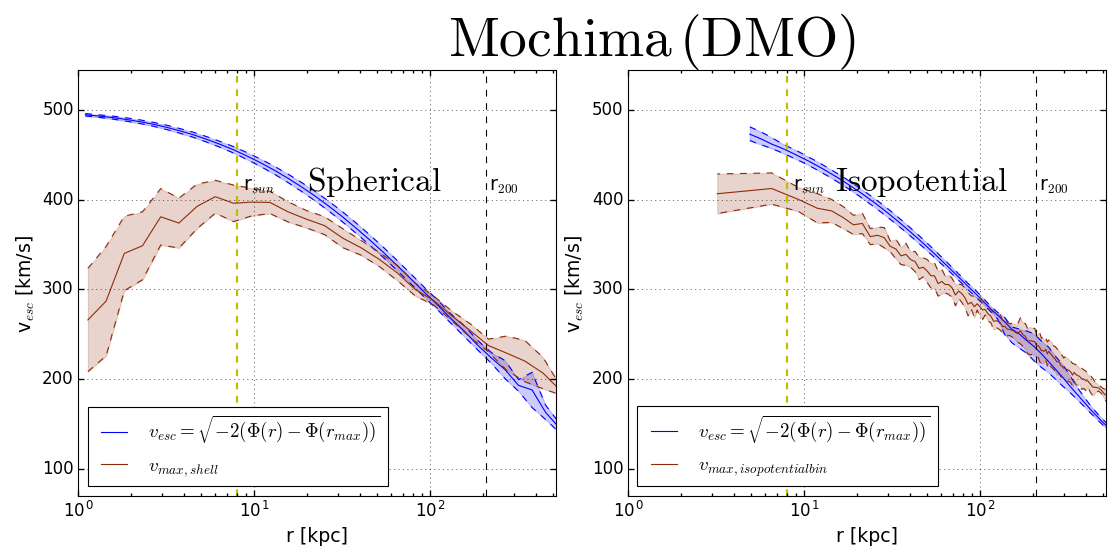

In [92]:
fig, [ax,ax1] = plt.subplots(1,2,figsize=[14,7])
fig.text(0.4,0.9,r"$\rm "+simname+"\,(DMO)$",fontsize=50)
#########################33
ax.set_xlim([1,2.5*myDMO.r200])
ax.set_ylim([70,1.1*v_esc.max()])
ax.set_xscale('log')
font = 17
##### from potential
ax.plot(r_phi_vesc, v_esc,'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax.plot(r_phi_vesc, v_esc+sig_vesc,'b--',markersize=3)
ax.plot(r_phi_vesc, v_esc-sig_vesc,'b--',markersize=3)
ax.fill_between(r_phi_vesc,v_esc+sig_vesc, v_esc-sig_vesc,color='b',alpha=0.2)
ax.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax.axvline(x=myDMO.r200,color='k',linestyle='--')
ax.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
##### from shell spherical assumption
ax.plot(r_phi_centers,vesc_per_radius[0],color="#902b08",linestyle="-",label=r"$v_{max,shell}$")
ax.plot(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],color="#902b08",linestyle="--")
ax.plot(r_phi_centers,vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",linestyle="--")
ax.fill_between(r_phi_centers,vesc_per_radius[0]+vesc_per_radius[1],vesc_per_radius[0]-vesc_per_radius[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
ax.text(myDMO.r200+10,410,r"r$_{200}$",fontsize=font)
ax.text(8.6,410,r"r$_{sun}$",fontsize=font)
ax.text(20,410,r"$\rm Spherical$",fontsize=30)
legend = ax.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="modified")
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
##############################################################################################
##############################################################################################
##############################################################################################

ax1.set_xlim([1,2.5*myDMO.r200])
ax1.set_ylim([70,1.1*v_esc.max()])
ax1.set_xscale('log')
font = 17
##### from potential
f_true = interp1d(r_from_phi, np.sqrt(2*cent_phi_bins))
f_plus = interp1d(r_from_phi+sig_r_from_phi, np.sqrt(2*cent_phi_bins))
f_min = interp1d(r_from_phi-sig_r_from_phi, np.sqrt(2*cent_phi_bins))
nunur = np.logspace(np.log10(1.1*(r_from_phi+sig_r_from_phi).min()),
                    np.log10(.9*(r_from_phi-sig_r_from_phi).max()),50)

ax1.plot(nunur,f_true(nunur),'b-',markersize=3,label=r"$v_{esc}=\sqrt{-2(\Phi(r)-\Phi(r_{max}))}$")
ax1.plot(nunur,f_plus(nunur),'b--',markersize=3)
ax1.plot(nunur, f_min(nunur),'b--',markersize=3)
ax1.fill_between(nunur,f_min(nunur),f_plus(nunur),color='b',alpha=0.2)
ax1.set_ylabel(r"v$_{esc}$ [km/s] ",fontsize=font)
ax1.axvline(x=myDMO.r200,color='k',linestyle='--')
ax1.axvline(x=8,color='y',linestyle='--',linewidth=2)
rr = (an_array[:-1]+an_array[1:])/2
ax.set_xlabel("r [kpc]",fontsize=font)
ax1.set_xlabel("r [kpc]",fontsize=font)

##### from shell 
ax1.plot(r_from_phi,vesc_per_pot[0],color="#902b08",linestyle="-",label=r"$v_{max,isopotential bin}$")
ax1.plot(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],color="#902b08",linestyle="--")
ax1.plot(r_from_phi,vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",linestyle="--")
ax1.fill_between(r_from_phi,vesc_per_pot[0]+vesc_per_pot[1],vesc_per_pot[0]-vesc_per_pot[1],color="#902b08",alpha=0.2)
#,yerr=vesc_per_radius[1], xerr=(an_array[1:]-an_array[:-1])/2,
######### second panel 
ax1.text(myDMO.r200+10,410,r"r$_{200}$",fontsize=font)
ax1.text(8.6,410,r"r$_{sun}$",fontsize=font)
ax1.text(15,410,r"$\rm Isopotential$",fontsize=30)
legend = ax1.legend(loc='lower left', ncol=1, shadow=False, fontsize=font)
frame = legend.get_frame()
fig.tight_layout(rect=(0,0,1,0.9))

#ax.plot(potdatHyd[:,0],np.sqrt(2*potdatHyd[:,1]),"r--", lw=2,label="reconstructed")
#ax.plot(r_mass,np.sqrt(2*np.abs(Psi2)),"k-", lw=1.5,label="modified")
ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


In [90]:
def fdv_plot_chi2_max_edd(ax, path, limmin, limmax,save=False,outname="/home/arturo/Pictures/ploto.png",width=None):
    # get eddington fdv from file
    v, fv = eddingtong_from_file(path)
    # interpolation of eddington points
    f = interp1d(v,fv)
    # get data points from simulations errors included
    # particles in the shell between limmin and limmax
    shell_wc = (myDMO.dm.r>limmin)&(myDMO.dm.r<limmax)
    if width == None:
        width = limmin /6.
    disc = (np.abs(myhydro.dm.pos3d[:,2])<width)
    local_v_wc = myhydro.dm.v[shell_wc]
    v_disc_in_the_shell = myhydro.dm.v[shell_wc&disc]
    Ntot=len(local_v_wc)
    # speed distribution in the shell
    bins = np.linspace(0,local_v_wc.max(),30)
    hist_wc, bins_wc = np.histogram(myhydro.dm.v[shell_wc],bins=bins,normed=True)
    x = (bins_wc[1:]+bins_wc[:-1])/2
    # considering informations from theory inside the bins
    fv_the = N = test = means= binsize = np.array([])
    for i in range(len(bins_wc)-1):
        pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
        if len(pop)==0:
            continue
        try:            
            fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
        except:
            test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
            fv_the = np.append(fv_the,0.0)
            pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
            means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
    dof = len(test)  
    # normalizations factor for data histogram
    ptot = np.sum(N)
    Ntot = np.trapz(np.nan_to_num(N),x=np.nan_to_num(means))

    ## MAXWELLIAN Fdv
    # circular velocity
    enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
    vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
    # for gas
    vc_gas = np.mean(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    std_vc_gas = np.std(myhydro.gs.vphi[(myhydro.gs.R>limmin)&(myhydro.gs.R<limmax)&(np.abs(myhydro.gs.pos3d[:,2])<2.)])
    vc_dm = np.nanmean(myhydro.dm.v[(myhydro.dm.R>limmin)&(myhydro.dm.R<limmax)&(np.abs(myhydro.dm.pos3d[:,2])<2.)])
    #for stars
    vc_stars = np.nanmean(myhydro.st.v[(myhydro.st.R>limmin)&(myhydro.st.R<limmax)&(np.abs(myhydro.st.pos3d[:,2])<2.)])
    std_vc_stars = np.nanstd(myhydro.st.v[(myhydro.st.r>limmin)&(myhydro.st.r<limmax)])    
    leno = len(myhydro.st.v[(myhydro.st.r<limmin)&(myhydro.st.r<limmax)])
    # this sigma is a parameter in the fdv not an error of any kind
    sigma_8  = vc / np.sqrt(2.)
    maxwellian = get_maxw(test,sigma_8)
    # normalizarion factor
    N0 = np.trapz(maxwellian, x=test)
    maxwellian /= N0
    ## CHI2 s 
    #error in data
    sigma = np.sqrt(N)/Ntot
    # eddington
    chi2 = np.nansum((((N/Ntot) - fv_the)**2 / (sigma**2))[(fv_the>0)])
    # maxwellian
    chi2_max = np.nansum((((N/Ntot) - maxwellian)**2 / (sigma**2)))
    #for i in range(len(N)):
    #    print test[i],((((N/Ntot) - fv_the)**2 / (fv_the**2)))[i],((((N/Ntot) - maxwellian)**2 / (maxwellian**2)))[i]
    # v escape from potential
    v_esc , sig_vesc = vesc_from_pot(limmin,limmax)
    # plotting
    ax.set_xlim([0,1.2*v_esc])
    ax.set_ylim([0,1.3*fv_the.max()])
    x=np.linspace(v[0],v[-2],100)
    ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")#,yerr=means/np.sqrt(N),xerr=sigma_x)
    ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:dof],c='g',lw=1.5,fmt=".", label="data")
    #ax.set_xlabel(r"$|\vec{v}|$ [km/s]",fontsize=16)
    ax.set_ylabel(r"$f(v) $ ",fontsize=22)
    ax.axvline(x=v_esc,color='k',linestyle='--')
    ax.axvspan(v_esc-sig_vesc, v_esc+sig_vesc, alpha=0.5, color='red',label=r"$v_{esc} \pm 1\sigma$ ")
    texto_max = r"$\rm Maxwellian$"+"\n"
    texto_max += r" $\chi^2_{red} = $"
    texto_max += r"${0:.2f}$".format(chi2_max/dof)
    texto_edd = r"$\rm Eddington$"+"\n"
    texto_edd += r" $\chi^2_{red} = $"
    texto_edd += r"${0:.2f}$".format(chi2/dof)
    texto_vc = r"$v_c ^{stars} =$ "
    texto_vc += r"${0:.2f}$".format(vc_stars,leno)
    texto_vc += "\n"
    texto_vc += "$dof = {0}$".format(dof)
    
    
    
    fig.text(0.15,0.75,texto_max,fontsize=16,color='r')
    fig.text(0.45,0.75,texto_edd,fontsize=16,color='k')
    fig.text(0.15,0.6,texto_vc,fontsize=16,color='k')
    fig.text(0.7,0.55,r"$\rm Hydro$",fontsize=26,color='k')

    ax.set_title(str(limmin)+" kpc < r < "+str(limmax)+" kpc ", fontsize=18)
    max_v = np.linspace(0,1.5*test.max(),50)
    ax.plot(max_v,get_maxw(max_v,sigma_8)/N0,'r-',lw=1.6,label=r"$\rm Maxwellian$")
    legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
    frame = legend.get_frame()
    if (save):
        plt.savefig(outname+".pdf",dpi=300)

In [91]:
fig, ax = plt.subplots(figsize=[10,5])
path = "../../datafiles/fv_cst_anis_beta_-0.2_halo_B_DM_baryons_Rmax=805.0kpc_8.0kpc.txt"
fdv_plot_chi2_max_edd(ax,path,7,9)
ax.set_xlabel("v",fontsize=20)
fig.tight_layout(h_pad=-0.4)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


<IPython.core.display.Javascript object>

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2090190 but corresponding boolean dimension is 2068441

# fig, ax = plt.subplots(figsize=[10,5])
path = "../../datafiles/fv_cst_anis_beta_-0.2_halo_B_DM_baryons_Rmax=805.0kpc_20.0kpc.txt"
fdv_plot_chi2_max_edd(ax,path,19,21)
ax.set_xlabel("v",fontsize=20)
fig.tight_layout(h_pad=-0.4)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)


# shape


In [ ]:
def dm(sim,lims,x,y,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,x], 
                                       sim.dm.pos3d[:,y],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass)
    result = H.T
    return result, edges

In [ ]:
length=51
hist2D, edges = dm(myhydro,[-length,length],0,2,250)
fig, ax = plt.subplots()
mass_1 = ax.imshow(hist2D, interpolation='nearest', origin='low',cmap="bone",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_1,cax=cax,label=r'mass [M$_{\odot}$]')



In [ ]:
histxz, edges = dm(myhydro,[-length,length],0,2,250)
histxy, edges = dm(myhydro,[-length,length],0,1,250)
histyz, edges = dm(myhydro,[-length,length],1,2,250)

fig, [ax1,ax,ax2] = plt.subplots(1,3,figsize=[20,7.5])
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = histxz
mass_1 = ax.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax.set_xlabel("x [kpc]",fontsize=20)
ax.set_ylabel("z [kpc]",fontsize=20)

Z = histxy
mass_1 = ax1.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax1.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax1.set_xlabel("x [kpc]",fontsize=20)
ax1.set_ylabel("y [kpc]",fontsize=20)

Z = histyz
mass_1 = ax2.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax2.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax2.set_xlabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)


In [ ]:
def pot(sim,lims,x,y,points):
    #disk = sim.st.pos3d[:,2]
    edges = np.linspace(lims[0],lims[1],points)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[:,x], 
                                       sim.dm.pos3d[:,y],
                                       bins=(edges, edges),
                                       weights=np.abs(Phy[:len(sim.dm.mass)]))
    result = H.T
    return result, edges

In [ ]:
histxz, edges = pot(myhydro,[-length,length],0,2,250)
histxy, edges = pot(myhydro,[-length,length],0,1,250)
histyz, edges = pot(myhydro,[-length,length],1,2,250)

fig, [ax1,ax,ax2] = plt.subplots(1,3,figsize=[20,7.5])
X, Y = np.meshgrid(edges[1:], edges[1:])
Z = histxz
mass_1 = ax.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax.set_xlabel("x [kpc]",fontsize=20)
ax.set_ylabel("z [kpc]",fontsize=20)

Z = histxy
mass_1 = ax1.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax1.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax1.set_xlabel("x [kpc]",fontsize=20)
ax1.set_ylabel("y [kpc]",fontsize=20)

Z = histyz
mass_1 = ax2.imshow(Z, interpolation='nearest', origin='low',cmap="magma",
                   extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5)
                  )


CS = ax2.contour(X, Y, Z,np.logspace(5,7,4),colors='w')
ax2.set_xlabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)

In [ ]:
m_hb_hyd = np.array([2262.42,171.52,684.43,131.23])
e_hb_hyd = np.array([424.87, 229.68, 133.97, 98.50])
m_hb_dmo = np.array([391.77,249.94,88.01,74.81])
e_hb_dmo = np.array([31.66, 63.81,88.38, 85.32])
m_mo_hyd = np.array([82.66,648.58,969.20,436.84])
e_mo_hyd = np.array([20.11, 17.8, 16.06, 13.48])
m_mo_dmo = np.array([ 25.48,16.58,129.57,108.77])
e_mo_dmo = np.array([23.46, 59.57, 87.62, 49.66])
r_co = np.array([3,8,20,50])

In [ ]:
fig, ax =plt.subplots()
ax.set_ylim([0,500])
ax.plot(r_co,m_hb_hyd,'r-.',lw=2)
ax.plot(r_co,e_hb_hyd,'k-.',lw=2)
ax.plot(r_co,m_hb_dmo,'r-',lw=2)
ax.plot(r_co,e_hb_dmo,"k-",lw=2)


# Bootstraping 

In [ ]:
# extern definitions
limmin , limmax = 2,4
#number of subsets
sub_n = 10000
# path to Edd results
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_3.0kpc_velocity_no_divergence.txt"
# get eddington fdv from file
v, fv = eddingtong_from_file(path)
# interpolation of eddington points
f = interp1d(v,fv)
x=np.linspace(v[0],v[-2],100)

shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
bins0  = np.linspace(0,myhydro.dm.v[shell].max(),30)
hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
sigma = np.sqrt(hist)/N
b_c = (bins[:-1]+bins[1:])/2
valid = (b_c<v.max())

fv_the = f(b_c[valid])
chi2 = np.nansum((((hist[valid]/N) - fv_the)**2 / (sigma[valid]**2)))/len(valid)
print chi2

enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
sigma_8  = vc / np.sqrt(2.)
ma = get_maxw(np.linspace(0,900,900),sigma_8)
N0 = np.trapz(ma, x=np.linspace(0,900,900))
maxwellian = get_maxw(b_c,sigma_8)
maxwellian /= N0
chi2_max = np.nansum((((hist/N) - maxwellian)**2 / (sigma**2)))/len(b_c)
print chi2_max

hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
def chi2_sub(ratio):
    subset = np.random.choice(len(myhydro.dm.v[shell]),len(shell[0])/ratio)
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    lambdas = (hist_sub/np.array(hist,dtype=float))
    sigma_sub = np.sqrt(lambdas*hist_sub*(np.ones(len(hist))+lambdas))/N_s
    b_c = (sub[:-1]+sub[1:])/2
    valid = (b_c<v.max())&(sigma_sub>0)&(hist_sub>0)
    fv_the = f(b_c[valid])
    chi2 = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    valid = (sigma_sub>0)&(hist_sub>0)
    maxwellian = get_maxw(b_c,sigma_8)
    maxwellian /= N0
    chi2_m = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    return [chi2,chi2_m]
#####################################################################################################
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ratio = 10.
ax.set_title(r"$\rm {0} \,kpc < r < {1}\, kpc$".format(limmin,limmax),fontsize=30)
for i in range(500):
    shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
    subset = np.random.choice(len(myhydro.dm.v[shell]),int(len(shell[0])/ratio))
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    ax.step(sub[:-1],hist_sub/N_s,'gray',alpha=0.5)




ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")

ax.step(sub[:-1],hist/N,'g',lw=3)
ax.plot(np.linspace(0,900,900),ma/N0,'r')
ax.set_xlabel(r"$\rm v [km/s]$",fontsize=30)
ax.set_ylabel(r"$\rm f(v)$",fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

# crate the chi2 dists
a=np.array([chi2_sub(10) for i in range(sub_n)])
chi2_dist = (a[:,0])[a[:,0]!=np.inf]
chi2_dist_m = (a[:,1])[a[:,1]!=np.inf]
times = 6
array_ed  = np.linspace(np.mean(chi2_dist)-(times*np.std(chi2_dist)),np.mean(chi2_dist)+(times*np.std(chi2_dist)),100)
h, bi = np.histogram(chi2_dist,bins=array_ed,normed=True)
#array_m  = np.linspace(np.mean(chi2_dist_m)-(times*np.std(chi2_dist_m)),np.mean(chi2_dist_m)+(times*np.std(chi2_dist_m)),100)
array_m  = np.linspace(1500,4000,100)
h_m, bi_m = np.histogram(chi2_dist_m,bins=array_m,normed=True)
#####################################################################################################
#####################################################################################################
#####################################################################################################
fig, ax = plt.subplots()
ax.step(bi[:-1],h,"k",lw=2,where='pre' )
ax.step(bi_m[:-1],h_m,"r",lw=2,where='pre' )

ax.set_ylabel(r"$f(\chi^2_{red})$", fontsize=25 )
ax.set_xlabel(r"$\chi^2_{red}$", fontsize=25 )
ax.text(1.2*np.mean(chi2_dist),0.8*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist)),fontsize=20)
ax.text(1.2*np.mean(chi2_dist),0.7*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist)),fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.6*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist_m)),color='r',fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.5*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist_m)),color='r',fontsize=20)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

In [ ]:
#extern definitions
limmin , limmax = 7,9
#number of subsets
sub_n = 10000
# path to Edd results
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_8.0kpc_velocity_no_divergence.txt"
# get eddington fdv from file
v, fv = eddingtong_from_file(path)
# interpolation of eddington points
f = interp1d(v,fv)
x=np.linspace(v[0],v[-2],100)

shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
bins0  = np.linspace(0,myhydro.dm.v[shell].max(),30)
hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
sigma = np.sqrt(hist)/N
b_c = (bins[:-1]+bins[1:])/2
valid = (b_c<v.max())

fv_the = f(b_c[valid])
chi2 = np.nansum((((hist[valid]/N) - fv_the)**2 / (sigma[valid]**2)))/len(valid)
print chi2

enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
sigma_8  = vc / np.sqrt(2.)
ma = get_maxw(np.linspace(0,900,900),sigma_8)
N0 = np.trapz(ma, x=np.linspace(0,900,900))
maxwellian = get_maxw(b_c,sigma_8)
maxwellian /= N0
chi2_max = np.nansum((((hist/N) - maxwellian)**2 / (sigma**2)))/len(b_c)
print chi2_max

hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
def chi2_sub(ratio):
    subset = np.random.choice(len(myhydro.dm.v[shell]),len(shell[0])/ratio)
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    lambdas = (hist_sub/np.array(hist,dtype=float))
    sigma_sub = np.sqrt(lambdas*hist_sub*(np.ones(len(hist))+lambdas))/N_s
    b_c = (sub[:-1]+sub[1:])/2
    valid = (b_c<v.max())&(sigma_sub>0)&(hist_sub>0)
    fv_the = f(b_c[valid])
    chi2 = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    valid = (sigma_sub>0)&(hist_sub>0)
    maxwellian = get_maxw(b_c,sigma_8)
    maxwellian /= N0
    chi2_m = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    return [chi2,chi2_m]
#####################################################################################################
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ratio = 10.
ax.set_title(r"$\rm {0} \,kpc < r < {1}\, kpc$".format(limmin,limmax),fontsize=30)
for i in range(500):
    shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
    subset = np.random.choice(len(myhydro.dm.v[shell]),int(len(shell[0])/ratio))
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    ax.step(sub[:-1],hist_sub/N_s,'gray',alpha=0.5)




ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")

ax.step(sub[:-1],hist/N,'g',lw=3)
ax.plot(np.linspace(0,900,900),ma/N0,'r')
ax.set_xlabel(r"$\rm v [km/s]$",fontsize=30)
ax.set_ylabel(r"$\rm f(v)$",fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

# crate the chi2 dists
a=np.array([chi2_sub(10) for i in range(sub_n)])
chi2_dist = (a[:,0])[a[:,0]!=np.inf]
chi2_dist_m = (a[:,1])[a[:,1]!=np.inf]
times = 6
array_ed  = np.linspace(np.mean(chi2_dist)-(times*np.std(chi2_dist)),np.mean(chi2_dist)+(times*np.std(chi2_dist)),100)
h, bi = np.histogram(chi2_dist,bins=array_ed,normed=True)
if np.mean(chi2_dist_m)-(times*np.std(chi2_dist_m))<0:
    ini = 0
else:
    ini = np.mean(chi2_dist_m)-(times*np.std(chi2_dist_m))
times=2
array_m  = np.linspace(ini,np.mean(chi2_dist_m)+(times*np.std(chi2_dist_m)),100)
h_m, bi_m = np.histogram(chi2_dist_m,bins=array_m,normed=True)
#####################################################################################################
#####################################################################################################
#####################################################################################################
fig, ax = plt.subplots()
ax.step(bi[:-1],h,"k",lw=2,where='pre' )
ax.step(bi_m[:-1],h_m,"r",lw=2,where='pre' )

ax.set_ylabel(r"$f(\chi^2_{red})$", fontsize=25 )
ax.set_xlabel(r"$\chi^2_{red}$", fontsize=25 )
ax.text(1.2*np.mean(chi2_dist),0.8*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist)),fontsize=20)
ax.text(1.2*np.mean(chi2_dist),0.7*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist)),fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.6*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist_m)),color='r',fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.5*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist_m)),color='r',fontsize=20)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

In [ ]:


def chi2_sub_sec(ratio):
    subset = np.random.choice(len(myhydro.dm.v[shell]),len(shell[0])/ratio)
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    lambdas = (hist_sub/np.array(hist,dtype=float))
    sigma_sub = np.sqrt(lambdas*hist_sub*(np.ones(len(hist))+lambdas))/N_s
    b_c = (sub[:-1]+sub[1:])/2
    maxwellian = get_maxw(b_c,sigma_8)
    maxwellian /= N0
    mean,std = np.mean(local_v),np.std(local_v)
    #valid = (b_c<v.max())&(sigma_sub>0)
    #low
    valid = (b_c<mean-std)&(sigma_sub>0)
    fv_the = f(b_c[valid])
    chi2_low = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    chi2_m_low = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    #mid
    valid = (b_c>mean-std)&(b_c<mean+std)&(sigma_sub>0)
    fv_the = f(b_c[valid])
    chi2_mid = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    chi2_m_mid = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    #high
    valid = (b_c>mean+std)&(b_c<v.max())&(sigma_sub>0)
    fv_the = f(b_c[valid])
    chi2_hig = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    valid = (b_c>mean+std)&(sigma_sub>0)
    chi2_m_hig = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    
    return [chi2_low,chi2_m_low,chi2_mid,chi2_m_mid,chi2_hig,chi2_m_hig]

a = np.array([chi2_sub_sec(10) for i in range(5000)])


In [ ]:
a[:,2]

In [ ]:
fig, ax= plt.subplots()
i=0
h, b = np.histogram((a[:,i])[(a[:,i]!=np.inf)],bins=100,normed=1)
ax.step(b[:-1],h)
i=2
h, b = np.histogram((a[:,i])[(a[:,i]!=np.inf)],bins=50,normed=1)
ax.step(b[:-1],h,'g' )
i=4
h, b = np.histogram((a[:,i])[(a[:,i]!=np.inf)],bins=50,normed=1)
ax.step(b[:-1],h,'r' )


In [ ]:
#extern definitions
limmin , limmax = 19,21
#number of subsets
sub_n = 5000
# path to Edd results
path = "../../datafiles/f_Eddington_halo_B_mass_model_Rmax=805.0kpc_20.0kpc_velocity_no_divergence.txt"
# get eddington fdv from file
v, fv = eddingtong_from_file(path)
# interpolation of eddington points
f = interp1d(v,fv)
x=np.linspace(v[0],v[-2],100)

shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
bins0  = np.linspace(0,myhydro.dm.v[shell].max(),30)
hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
sigma = np.sqrt(hist)/N
b_c = (bins[:-1]+bins[1:])/2
valid = (b_c<v.max())

fv_the = f(b_c[valid])
chi2 = np.nansum((((hist[valid]/N) - fv_the)**2 / (sigma[valid]**2)))/len(valid)
print chi2

enclosed_m = (np.sum(mass[np.where(r2<limmin**2)])+ np.sum(mass[np.where(r2<limmax**2)]))/2.
vc = np.sqrt(myhydro.p.G * enclosed_m / ((limmin + limmax) /2. )) * myhydro.p.kpctokm
sigma_8  = vc / np.sqrt(2.)
ma = get_maxw(np.linspace(0,900,900),sigma_8)
N0 = np.trapz(ma, x=np.linspace(0,900,900))
maxwellian = get_maxw(b_c,sigma_8)
maxwellian /= N0
chi2_max = np.nansum((((hist/N) - maxwellian)**2 / (sigma**2)))/len(b_c)
print chi2_max

hist, bins = np.histogram(myhydro.dm.v[shell],bins=bins0)
N = hist.sum()*(bins[1]-bins[0])
def chi2_sub(ratio):
    subset = np.random.choice(len(myhydro.dm.v[shell]),len(shell[0])/ratio)
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    lambdas = (hist_sub/np.array(hist,dtype=float))
    sigma_sub = np.sqrt(lambdas*hist_sub*(np.ones(len(hist))+lambdas))/N_s
    b_c = (sub[:-1]+sub[1:])/2
    valid = (b_c<v.max())&(sigma_sub>0)
    fv_the = f(b_c[valid])
    chi2 = np.nansum((((hist_sub[valid]/N_s) - fv_the)**2 / (sigma_sub[valid]**2)))/len(valid)
    valid = (sigma_sub>0)
    maxwellian = get_maxw(b_c,sigma_8)
    maxwellian /= N0
    chi2_m = np.nansum((((hist_sub[valid]/N_s) - maxwellian[valid])**2 / (sigma_sub[valid]**2)))/len(b_c[valid])
    return [chi2,chi2_m]
#####################################################################################################
#####################################################################################################
#####################################################################################################

fig, ax = plt.subplots()
ratio = 10.
ax.set_title(r"$\rm {0} \,kpc < r < {1}\, kpc$".format(limmin,limmax),fontsize=30)
for i in range(500):
    shell = np.where((myhydro.dm.r>limmin)&(myhydro.dm.r<limmax))
    subset = np.random.choice(len(myhydro.dm.v[shell]),int(len(shell[0])/ratio))
    local_v = myhydro.dm.v[shell]
    hist_sub, sub = np.histogram(local_v[subset],bins=bins0)
    N_s = hist_sub.sum()*(sub[1]-sub[0])
    ax.step(sub[:-1],hist_sub/N_s,'gray',alpha=0.5)




ax.plot(x,f(x),'k-',lw=1.6,label=r"$\rm Eddington$")

ax.step(sub[:-1],hist/N,'g',lw=3)
ax.plot(np.linspace(0,900,900),ma/N0,'r')
ax.set_xlabel(r"$\rm v [km/s]$",fontsize=30)
ax.set_ylabel(r"$\rm f(v)$",fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout()

# crate the chi2 dists
a=np.array([chi2_sub(10) for i in range(sub_n)])
chi2_dist = (a[:,0])[a[:,0]!=np.inf]
chi2_dist_m = (a[:,1])[a[:,1]!=np.inf]
times = 6
array_ed  = np.linspace(np.mean(chi2_dist)-(times*np.std(chi2_dist)),np.mean(chi2_dist)+(times*np.std(chi2_dist)),100)
h, bi = np.histogram(chi2_dist,bins=array_ed,normed=True)
array_m  = np.linspace(np.mean(chi2_dist_m)-(times*np.std(chi2_dist_m)),np.mean(chi2_dist_m)+(times*np.std(chi2_dist_m)),100)
h_m, bi_m = np.histogram(chi2_dist_m,bins=array_m,normed=True)
#####################################################################################################
#####################################################################################################
#####################################################################################################
fig, ax = plt.subplots()
ax.step(bi[:-1],h,"k",lw=2,where='pre' )
ax.step(bi_m[:-1],h_m,"r",lw=2,where='pre' )

ax.set_ylabel(r"$f(\chi^2_{red})$", fontsize=25 )
ax.set_xlabel(r"$\chi^2_{red}$", fontsize=25 )
ax.text(1.2*np.mean(chi2_dist),0.8*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist)),fontsize=20)
ax.text(1.2*np.mean(chi2_dist),0.7*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist)),fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.6*h.max(),r"$\rm \mu = {0:.1f}$".format(np.mean(chi2_dist_m)),color='r',fontsize=20)
ax.text(1.3*np.mean(chi2_dist_m),0.5*h.max(),r"$\rm \sigma = {0:.1f}$".format(np.std(chi2_dist_m)),color='r',fontsize=20)
fig.tight_layout()
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)

# V_rel 

In [ ]:
limmin, limmax = 7,9
comp = 0
my_v = myhydro.dm.vel3d[(myhydro.dm.r>limmin)&((myhydro.dm.r<limmax)),comp]
a= my_v
result = np.array([])
def summa(i):
    return a[i]-a[i+1:]
    
sumi = np.vectorize(summa)
for i in range(len(a)):
    result = np.append(result,sumi(i))

In [ ]:
len(result)

In [ ]:
jobs

In [ ]:
fig, ax =plt.subplots()
x = np.linspace(0,1600,400)
y=stats.chi2(29).pdf(x)
ax.fill_between(x,0,y)

In [ ]:
sortingR = np.argsort(myDMO.dm.r)
print myDMO.dm.r[sortingR]

In [ ]:
cumsum = np.cumsum(myDMO.dm.mass[sortingR]) 

In [ ]:
vol = (4./3.)*np.pi*(myDMO.dm.r[sortingR]**3)

In [ ]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xscale('log')
ax.axhline(y=200*myDMO.p.rho_crit)
ax.axhline(y=200*myDMO.p.rho_crit*0.7**2)

ax.plot(myDMO.dm.r[sortingR],cumsum/vol)
ax.axvline(x=122)
ax.axvline(x=176)

In [ ]:
np.unique(myDMO.dm.mass[myDMO.dm.r<200])[0]

In [ ]:
myDMO.dm.r[sortingR].max()

In [ ]:
print myDMO.p.rho_crit*1e3*myDMO.p.pctocm

In [ ]:
massinside = np.sum(myDMO.dm.mass[myDMO.dm.r<176])

print "mass = {0:.2e}".format(massinside)
print "vol  = {0:.2e}".format((4.*np.pi*(myDMO.r200**3)/3.))
print "ratio  = {0:.2e}".format(massinside/(4.*np.pi*(myDMO.r200**3)/3.))
print "200*rho_crit  = {0:.2e}".format(200*myDMO.p.rho_crit)



In [ ]:
fig,ax = plt.subplots()
def face_on_dm(sim,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    selection = (sim.dm.r<400)&(sim.dm.pos3d[:,2]>0)
    H, xedges, yedges = np.histogram2d(sim.dm.pos3d[selection,0],
                                       sim.dm.pos3d[selection,1],
                                       bins=(edges, edges),
                                       weights=sim.dm.mass[selection])
    result = H.T
    return result, edges


mymatrix,edges = face_on_dm(myDMO,[-200,200],300)

mass_2 = ax.imshow(mymatrix, interpolation='nearest', origin='low',cmap='rainbow',
                    extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e5,vmax=1e9)
                  )


circle = plt.Circle((0,0),myDMO.r200, color='k',lw=0.9, fill=False)
ax.add_patch( circle )

circle = plt.Circle((0,0),176, color='k',linestyle='--', lw=0.9, fill=False)
ax.add_patch( circle )

In [20]:
def pot_map(x,y,z,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    pot = (Phy[:len(myhydro.dm.mass)])
    disc = np.where(np.abs(myhydro.dm.pos3d[:,z])<20)[0]
    H, xedges, yedges = np.histogram2d(myhydro.dm.pos3d[disc,x],
                                       myhydro.dm.pos3d[disc,y],
                                       bins=(edges, edges),
                                       weights=pot[disc])
    result = H.T
    return result, edges

def pot_mapDMO(x,y,z,lims,points):
    edges = np.linspace(lims[0],lims[1],points)
    pot = (PhyDMO[:len(myDMO.dm.mass)])
    disc = np.where(np.abs(myDMO.dm.pos3d[:,z])<20)[0]
    H, xedges, yedges = np.histogram2d(myDMO.dm.pos3d[disc,x],
                                       myDMO.dm.pos3d[disc,y],
                                       bins=(edges, edges),
                                       weights=pot[disc])
    result = H.T
    return result, edges

<IPython.core.display.Javascript object>


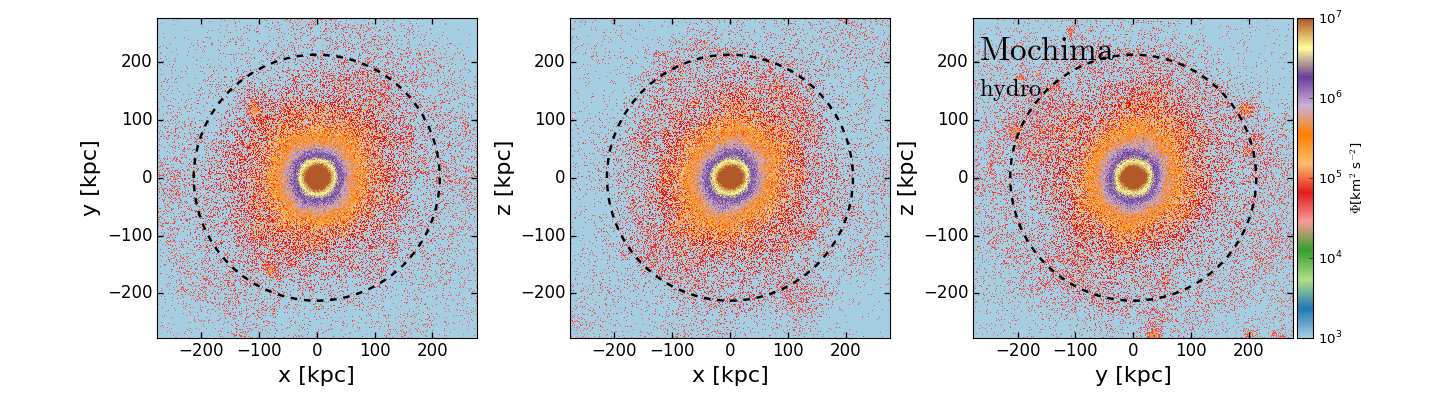

In [21]:
length=1.3*myhydro.r200
fig, [ax,ax1,ax2] = plt.subplots(1,3,figsize=[18,5])
the_mapxy,edges= pot_map(1,0,2,[-length,length],350)#H.T 

mass_2 = ax.imshow(-the_mapxy+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))
##############################################################33
the_mapxz,edges= pot_map(0,2,1,[-length,length],350)#H.T 

mass_2 = ax1.imshow(-the_mapxz+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax1.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))


##############################################################33
the_mapyz,edges= pot_map(1,2,0,[-length,length],350)#H.T 

mass_2 = ax2.imshow(-the_mapyz+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax2.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))

divider = make_axes_locatable(ax2)
fig.text(0.68,0.85,r"$\rm "+hydro.namenospace+"$",fontsize=30)
fig.text(0.68,0.76,r"$\rm "+hydro.version+"$",fontsize=22)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'$\Phi$[km$^2$ s$^{-2}$]')
ax.set_xlabel("x [kpc]",fontsize=20)
ax.set_ylabel("y [kpc]",fontsize=20)
ax1.set_xlabel("x [kpc]",fontsize=20)
ax1.set_ylabel("z [kpc]",fontsize=20)
ax2.set_xlabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax2.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax2.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout(w_pad=-9)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+hydro.namenospace+"/HYDRO/potential_map_"+hydro.namenospace+"_hydro.png")

In [23]:
print myhydro.r200

212.6953125


In [27]:
vel = myDMO.dm.vel3d[np.where(myDMO.dm.r<0.3*myDMO.r200)]
poss = myDMO.dm.pos3d[np.where(myDMO.dm.r<0.3*myDMO.r200)]
masss = myDMO.dm.mass[np.where(myDMO.dm.r<0.3*myDMO.r200)]
D,T = nbe.mass_distribution_tensor(masss,poss)
myDMO.dm.rotate(T)

In [28]:
print D

[[ 2.16204189e+14 -1.50975438e-02 -4.75564925e-03]
 [-1.45209270e-02  1.51361718e+14  3.93811847e-02]
 [-9.59009362e-03  4.82454120e-02  1.34946093e+14]]


<IPython.core.display.Javascript object>


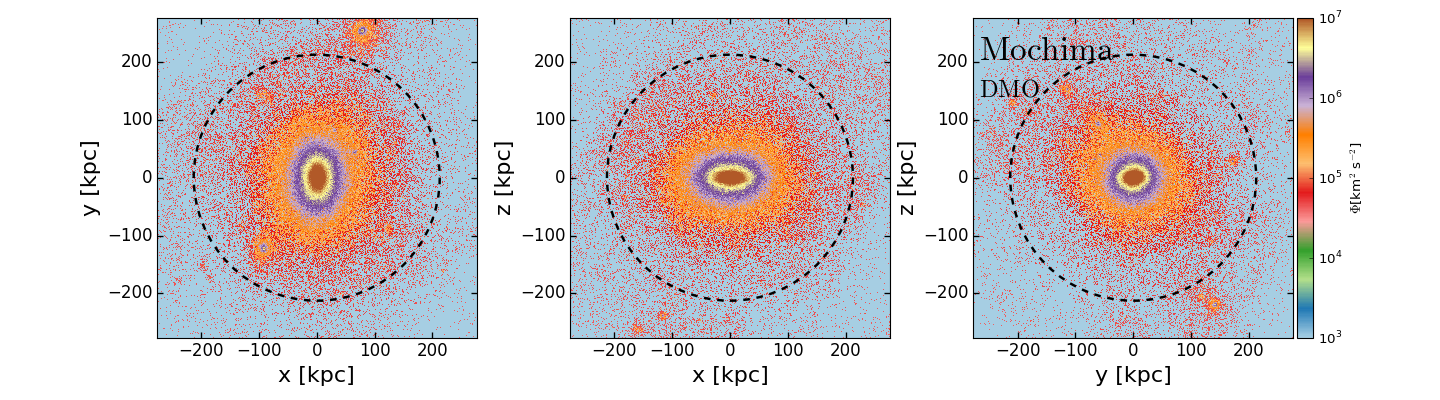

In [29]:
length=1.3*myhydro.r200
fig, [ax,ax1,ax2] = plt.subplots(1,3,figsize=[18,5])
the_mapxy,edges= pot_mapDMO(1,0,2,[-length,length],350)#H.T 

mass_2 = ax.imshow(-the_mapxy+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))
##############################################################33
the_mapxz,edges= pot_mapDMO(0,2,1,[-length,length],350)#H.T 

mass_2 = ax1.imshow(-the_mapxz+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax1.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))


##############################################################33
the_mapyz,edges= pot_mapDMO(1,2,0,[-length,length],350)#H.T 

mass_2 = ax2.imshow(-the_mapyz+20, interpolation='nearest', origin='low',cmap='Paired',
                       extent=[edges[0], edges[-1], edges[0], edges[-1]],
                   norm=LogNorm(vmin=1e3,vmax=1e7)
                  )

ax2.add_artist(Circle(xy=(0, 0),radius=myhydro.r200,color='k',ls='--',lw=2.2,fill=False))

divider = make_axes_locatable(ax2)
fig.text(0.68,0.85,r"$\rm "+dmo.namenospace+"$",fontsize=30)
fig.text(0.68,0.76,r"$\rm "+dmo.version+"$",fontsize=22)

cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(mass_2,cax=cax,label=r'$\Phi$[km$^2$ s$^{-2}$]')
ax.set_xlabel("x [kpc]",fontsize=20)
ax.set_ylabel("y [kpc]",fontsize=20)
ax1.set_xlabel("x [kpc]",fontsize=20)
ax1.set_ylabel("z [kpc]",fontsize=20)
ax2.set_xlabel("y [kpc]",fontsize=20)
ax2.set_ylabel("z [kpc]",fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax1.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax1.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
ax2.tick_params(axis='both', which='major', labelsize=15, size=5,width=1.2)
ax2.tick_params(axis='both', which='minor', labelsize=15, size=3,width=1.2)
fig.tight_layout(w_pad=-9)
plt.savefig("/home/arturo/Documents/LAM/LAM2LUPM/"+dmo.namenospace+"/DMO/potential_map_"+dmo.namenospace+"_DMO.png")